#**Trabalho Prático 1**

In [1]:
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import RidgeCV
import seaborn as sns
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer
from sklearn.base import clone
from sklearn.impute import SimpleImputer
from sklearn.neighbors import KNeighborsRegressor
import time

##**Task 1**

###Task 1 - Setting the Baseline

In [8]:
#Carregar os dados
X_train_df = pd.read_csv("X_train.csv")
X_test_df = pd.read_csv("X_test.csv")
X_train_df.head()
print(X_train_df.shape)

(1285000, 14)


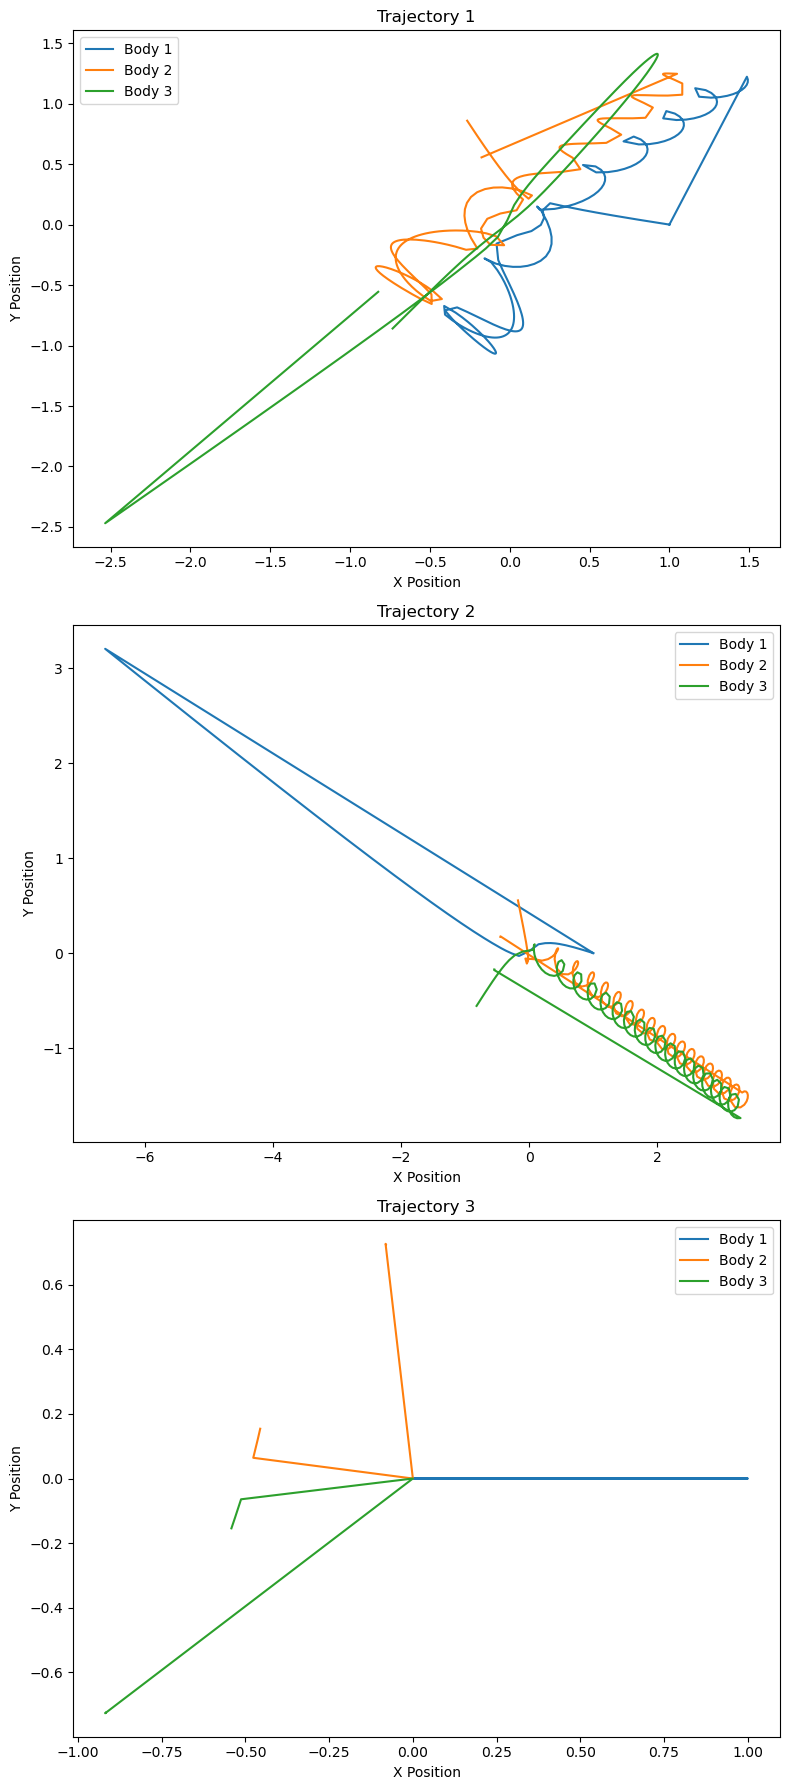

In [4]:
# Trajetorias
traj_length = 258
num_trajectories = len(X_train_df) // traj_length
num_plots = 3
fig, axes = plt.subplots(num_plots, 1, figsize=(8, 6 * num_plots), squeeze=False)

for i in range(num_plots):
    start = i * traj_length
    end = start + traj_length
    traj = X_train_df.iloc[start:end]

    # Plot positions for each body
    axes[i, 0].plot(traj['x_1'], traj['y_1'], label='Body 1')
    axes[i, 0].plot(traj['x_2'], traj['y_2'], label='Body 2')
    axes[i, 0].plot(traj['x_3'], traj['y_3'], label='Body 3')
    axes[i, 0].set_title(f"Trajectory {i+1}")
    axes[i, 0].set_xlabel('X Position')
    axes[i, 0].set_ylabel('Y Position')
    axes[i, 0].legend()

plt.tight_layout()
plt.show()

In [5]:
X_train_df.head()

,t,x_1,y_1,v_x_1,v_y_1,x_2,y_2,v_x_2,v_y_2,x_3,y_3,v_x_3,v_y_3,Id
0,0.000000,1.000000,0.000000,0.000000,0.000000,-0.266467,0.859196,0.000000,0.000000,-0.733533,-0.859196,0.000000,0.000000,0
1,0.039062,0.999548,0.000092,-0.023159,0.004731,-0.266261,0.858781,0.010574,-0.021257,-0.733287,-0.858874,0.012584,0.016526,1
2,0.078125,0.998190,0.000370,-0.046362,0.009474,-0.265641,0.857535,0.021172,-0.042552,-0.732549,-0.857905,0.025189,0.033078,2
3,0.117188,0.995925,0.000833,-0.069654,0.014239,-0.264606,0.855456,0.031817,-0.063924,-0.731318,-0.856289,0.037837,0.049685,3
4,0.156250,0.992747,0.001483,-0.093080,0.019040,-0.263154,0.852540,0.042533,-0.085412,-0.729592,-0.854022,0.050548,0.066372,4


In [9]:
X_train_df.drop('Id', axis=1, inplace = True)
X_train_df['all_zero'] = (X_train_df == 0).all(axis=1)
X_train_df.head()

,t,x_1,y_1,v_x_1,v_y_1,x_2,y_2,v_x_2,v_y_2,x_3,y_3,v_x_3,v_y_3,all_zero
0,0.000000,1.000000,0.000000,0.000000,0.000000,-0.266467,0.859196,0.000000,0.000000,-0.733533,-0.859196,0.000000,0.000000,False
1,0.039062,0.999548,0.000092,-0.023159,0.004731,-0.266261,0.858781,0.010574,-0.021257,-0.733287,-0.858874,0.012584,0.016526,False
2,0.078125,0.998190,0.000370,-0.046362,0.009474,-0.265641,0.857535,0.021172,-0.042552,-0.732549,-0.857905,0.025189,0.033078,False
3,0.117188,0.995925,0.000833,-0.069654,0.014239,-0.264606,0.855456,0.031817,-0.063924,-0.731318,-0.856289,0.037837,0.049685,False
4,0.156250,0.992747,0.001483,-0.093080,0.019040,-0.263154,0.852540,0.042533,-0.085412,-0.729592,-0.854022,0.050548,0.066372,False


In [10]:
# Definir trajetorias
X_train_df['traj_id'] = (X_train_df.index //traj_length) +1
X_train_df.set_index(['traj_id', X_train_df.index], inplace=True)
X_train_df

t       x_1       y_1     v_x_1     v_y_1       x_2  \
traj_id                                                                        
1       0         0.000000  1.000000  0.000000  0.000000  0.000000 -0.266467   
        1         0.039062  0.999548  0.000092 -0.023159  0.004731 -0.266261   
        2         0.078125  0.998190  0.000370 -0.046362  0.009474 -0.265641   
        3         0.117188  0.995925  0.000833 -0.069654  0.014239 -0.264606   
        4         0.156250  0.992747  0.001483 -0.093080  0.019040 -0.263154   
...                    ...       ...       ...       ...       ...       ...   
4981    1284995   9.843750 -0.022787 -0.354678 -1.450539 -0.511101 -0.128897   
        1284996   9.882810 -0.082072 -0.384254 -1.556362 -1.038875 -0.084507   
        1284997   9.921880 -0.140434 -0.438907 -1.348462 -1.794786 -0.040823   
        1284998   9.960940 -0.177344 -0.524277 -0.380080 -2.492241 -0.018380   
        1284999  10.000000 -0.163264 -0.618197  1.029575 -2.079003 -0.046730   

                      y_2     v_x_2     v_y_2       x_3       y_3     v_x_3  \
traj_id                                                                       
1       0        0.859196  0.000000  0.000000 -0.733533 -0.859196  0.000000   
        1        0.858781  0.010574 -0.021257 -0.733287 -0.858874  0.012584   
        2        0.857535  0.021172 -0.042552 -0.732549 -0.857905  0.025189   
        3        0.855456  0.031817 -0.063924 -0.731318 -0.856289  0.037837   
        4        0.852540  0.042533 -0.085412 -0.729592 -0.854022  0.050548   
...                   ...       ...       ...       ...       ...       ...   
4981    1284995 -0.618452  1.066492 -0.497032  0.151684  0.973131  0.384048   
        1284996 -0.627569  1.177829  0.065469  0.166578  1.011822  0.378533   
        1284997 -0.610311  0.975436  0.853069  0.181257  1.049218  0.373027   
        1284998 -0.561151  0.012292  1.579595  0.195724  1.085428  0.367788   
        1284999 -0.502346 -1.392434  1.193499  0.209994  1.120543  0.362860   

                    v_y_3  all_zero  
traj_id                              
1       0        0.000000     False  
        1        0.016526     False  
        2        0.033078     False  
        3        0.049685     False  
        4        0.066372     False  
...                   ...       ...  
4981    1284995  1.008133     False  
        1284996  0.973406     False  
        1284997  0.941717     False  
        1284998  0.912645     False  
        1284999  0.885505     False  

[1285000 rows x 14 columns]

In [12]:
# Posições iniciais
initial_positions = X_train_df[X_train_df['t'] == 0].copy()  
initial_positions = initial_positions[initial_positions['all_zero'] == False]  
initial_positions = initial_positions.groupby('traj_id').first().reset_index()
print(initial_positions.head())
print(initial_positions.shape)

   traj_id    t  x_1  y_1  v_x_1  v_y_1       x_2       y_2  v_x_2  v_y_2  \
0        1  0.0  1.0  0.0    0.0    0.0 -0.266467  0.859196    0.0    0.0   
1        2  0.0  1.0  0.0    0.0    0.0 -0.450789  0.177112    0.0    0.0   
2        3  0.0  1.0  0.0    0.0    0.0 -0.081487  0.726750    0.0    0.0   
3        4  0.0  1.0  0.0    0.0    0.0 -0.276940  0.910726    0.0    0.0   
4        5  0.0  1.0  0.0    0.0    0.0 -0.471512  0.002251    0.0    0.0   

        x_3       y_3  v_x_3  v_y_3  all_zero  
0 -0.733533 -0.859196    0.0    0.0     False  
1 -0.549211 -0.177112    0.0    0.0     False  
2 -0.918513 -0.726750    0.0    0.0     False  
3 -0.723060 -0.910726    0.0    0.0     False  
4 -0.528488 -0.002251    0.0    0.0     False  
(4978, 15)


In [13]:
# Dataframe completo
initial_positions = initial_positions.rename(columns={
    'x_1': 'x0_1', 'y_1': 'y0_1',
    'x_2': 'x0_2', 'y_2': 'y0_2',
    'x_3': 'x0_3', 'y_3': 'y0_3'
})

colunas = ['traj_id', 'x0_1', 'y0_1', 'x0_2', 'y0_2', 'x0_3', 'y0_3']
initial_positions = initial_positions[colunas]

X_train_joined = X_train_df.merge(initial_positions, on='traj_id', how='left')
X_train_joined.drop('all_zero', axis=1, inplace=True)
X_train_joined = X_train_joined.dropna()

print(X_train_joined.head())
print(X_train_joined.shape)

   traj_id         t       x_1       y_1     v_x_1     v_y_1       x_2  \
0        1  0.000000  1.000000  0.000000  0.000000  0.000000 -0.266467   
1        1  0.039062  0.999548  0.000092 -0.023159  0.004731 -0.266261   
2        1  0.078125  0.998190  0.000370 -0.046362  0.009474 -0.265641   
3        1  0.117188  0.995925  0.000833 -0.069654  0.014239 -0.264606   
4        1  0.156250  0.992747  0.001483 -0.093080  0.019040 -0.263154   

        y_2     v_x_2     v_y_2       x_3       y_3     v_x_3     v_y_3  x0_1  \
0  0.859196  0.000000  0.000000 -0.733533 -0.859196  0.000000  0.000000   1.0   
1  0.858781  0.010574 -0.021257 -0.733287 -0.858874  0.012584  0.016526   1.0   
2  0.857535  0.021172 -0.042552 -0.732549 -0.857905  0.025189  0.033078   1.0   
3  0.855456  0.031817 -0.063924 -0.731318 -0.856289  0.037837  0.049685   1.0   
4  0.852540  0.042533 -0.085412 -0.729592 -0.854022  0.050548  0.066372   1.0   

   y0_1      x0_2      y0_2      x0_3      y0_3  
0   0.0 -0.266467 

In [14]:
# Features:  posições iniciais
feature_cols = ['t','x0_1', 'y0_1', 'x0_2', 'y0_2', 'x0_3', 'y0_3']
x = X_train_joined[feature_cols]


# Targets: posições atuais
target_cols = ['x_1', 'y_1', 'x_2', 'y_2', 'x_3', 'y_3']
y = X_train_joined[target_cols]

print(x.head())
print(y.head())
print(x.shape)


          t  x0_1  y0_1      x0_2      y0_2      x0_3      y0_3
0  0.000000   1.0   0.0 -0.266467  0.859196 -0.733533 -0.859196
1  0.039062   1.0   0.0 -0.266467  0.859196 -0.733533 -0.859196
2  0.078125   1.0   0.0 -0.266467  0.859196 -0.733533 -0.859196
3  0.117188   1.0   0.0 -0.266467  0.859196 -0.733533 -0.859196
4  0.156250   1.0   0.0 -0.266467  0.859196 -0.733533 -0.859196
        x_1       y_1       x_2       y_2       x_3       y_3
0  1.000000  0.000000 -0.266467  0.859196 -0.733533 -0.859196
1  0.999548  0.000092 -0.266261  0.858781 -0.733287 -0.858874
2  0.998190  0.000370 -0.265641  0.857535 -0.732549 -0.857905
3  0.995925  0.000833 -0.264606  0.855456 -0.731318 -0.856289
4  0.992747  0.001483 -0.263154  0.852540 -0.729592 -0.854022
(1284324, 7)


In [15]:
# Divisao dos dados apartir das trajetorias
init_df = X_train_joined[X_train_joined['t'] == 0][['traj_id']]
init_df = init_df.drop_duplicates()

train_init, val_init = train_test_split(init_df, test_size=0.2, random_state=42)
X_train_split = X_train_joined[X_train_joined['traj_id'].isin(train_init['traj_id'])]
X_val_split = X_train_joined[X_train_joined['traj_id'].isin(val_init['traj_id'])]

X_train_final = X_train_split[feature_cols]
y_train_final = X_train_split[target_cols]
X_val_final = X_val_split[feature_cols]
y_val_final = X_val_split[target_cols]


# Alinhar indices
X_train_final = X_train_final.reset_index(drop=True)
y_train_final = y_train_final.reset_index(drop=True)
X_val_final = X_val_final.reset_index(drop=True)
y_val_final = y_val_final.reset_index(drop=True)


print(X_val_final.shape)
print(y_val_final.shape)
print(X_train_final.shape)
print(y_train_final.shape)

(256968, 7)
(256968, 6)
(1027356, 7)
(1027356, 6)


In [17]:
#Pipeline
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('regressor', LinearRegression())
])
pipeline.fit(X_train_final, y_train_final)

Pipeline(steps=[('scaler', StandardScaler()),
                ('regressor', LinearRegression())])

In [ ]:
# Previsões com o modelo treinado no conjunto de validação
y_pred = pipeline.predict(X_val_final)

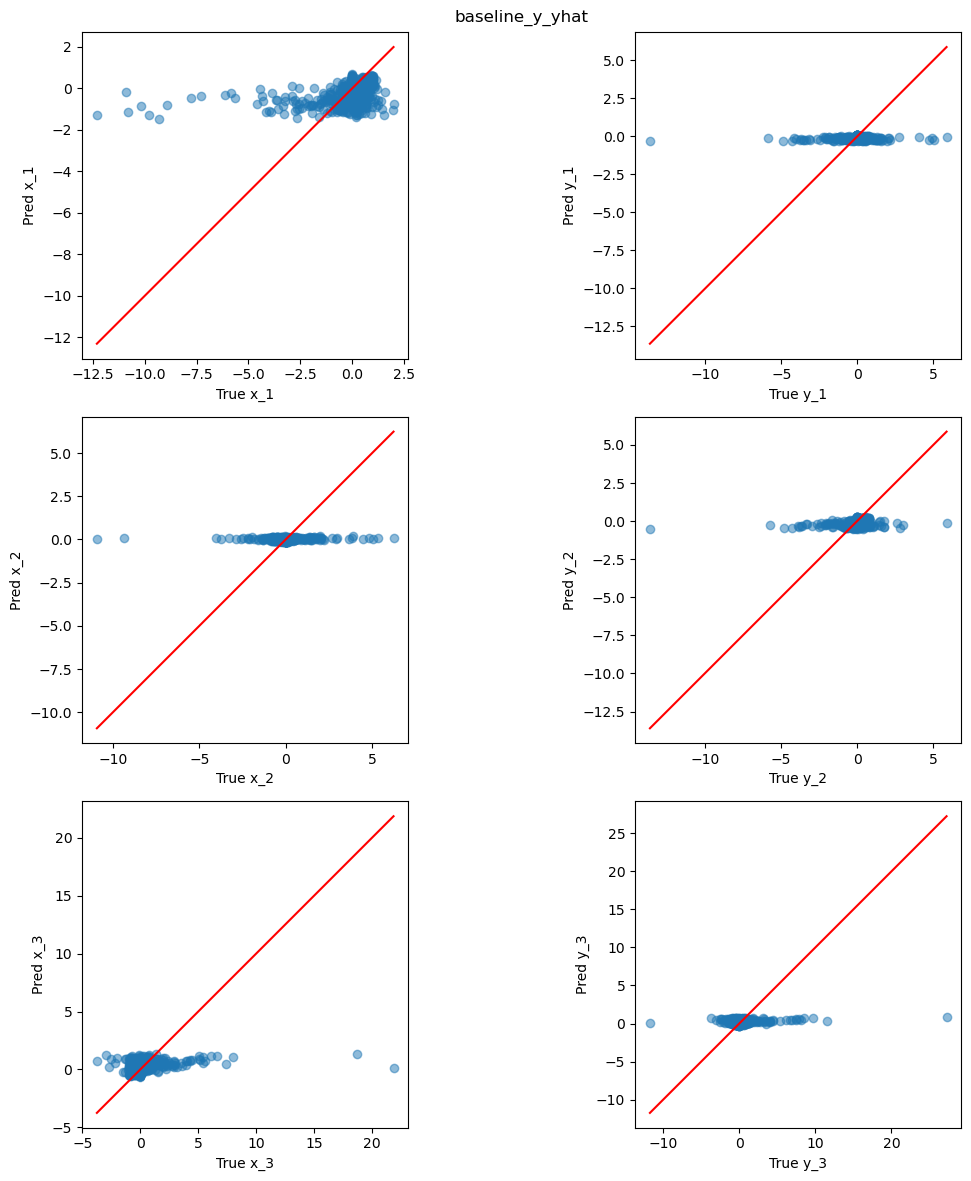

<Figure size 640x480 with 0 Axes>

In [19]:
#Função para realizar os gráficos
def plot(y_test, y_pred, plot_title="plot"):
    labels = ['x_1', 'y_1', 'x_2', 'y_2', 'x_3', 'y_3']
    MAX = 500
    idx = np.random.choice(len(y_test), min(MAX, len(y_test)), replace=False)

    plt.figure(figsize=(12,12))

    # Cria um gráfico para cada variável de saída 
    for i in range(6):
        x0, x1 = np.min(y_test.iloc[idx, i]), np.max(y_test.iloc[idx, i])
        plt.subplot(3, 2, i + 1)
        plt.scatter(y_test.iloc[idx, i], y_pred[idx, i], alpha=0.5)
        plt.xlabel(f"True {labels[i]}")
        plt.ylabel(f"Pred {labels[i]}")
        plt.plot([x0, x1], [x0, x1], color="red")
        plt.axis("square")
    plt.suptitle(plot_title)
    plt.tight_layout()
    plt.show()
    plt.savefig('baseline.pdf')

 # Gerar o gráfico
plot(y_val_final, y_pred, plot_title="baseline_y_yhat")

In [20]:
X_test_df

,Id,t,x0_1,y0_1,x0_2,y0_2,x0_3,y0_3
0,0,0.000000,1.0,0.0,-0.179617,0.730085,-0.820383,-0.730085
1,1,0.039062,1.0,0.0,-0.179617,0.730085,-0.820383,-0.730085
2,2,0.078125,1.0,0.0,-0.179617,0.730085,-0.820383,-0.730085
3,3,0.117188,1.0,0.0,-0.179617,0.730085,-0.820383,-0.730085
4,4,0.156250,1.0,0.0,-0.179617,0.730085,-0.820383,-0.730085
...,...,...,...,...,...,...,...,...
1041616,1041616,9.843750,1.0,0.0,-0.207166,0.852911,-0.792834,-0.852911
1041617,1041617,9.882810,1.0,0.0,-0.207166,0.852911,-0.792834,-0.852911
1041618,1041618,9.921880,1.0,0.0,-0.207166,0.852911,-0.792834,-0.852911
1041619,1041619,9.960940,1.0,0.0,-0.207166,0.852911,-0.792834,-0.852911


In [21]:
# Avaliação do modelo com o RMSE
rmse_test = np.sqrt(mean_squared_error(y_pred, y_val_final))
print(f"RMSE: {rmse_test:.6f}")

RMSE: 1.405752


In [ ]:
# Previsões com o modelo treinado no conjunto de Test
X_test = X_test_df.drop('Id', axis=1)
predictions = pipeline.predict(X_test)
print(predictions.shape)

(1041621, 6)


In [ ]:
#Ficheiro para submeter
labels = ['x_1', 'y_1', 'x_2', 'y_2', 'x_3', 'y_3']
predictions_df = pd.DataFrame(predictions, columns=labels)
predictions_df.insert(0, 'id', range(len(predictions)))
predictions_df.to_csv('baseline-model.csv', index=False)
predictions_df.shape

(1041621, 7)

##**Task 2**

###Task 2 - Nonlinear models on the data - The Polynomial Regression model

In [ ]:
#Separar os dados em samples, para reduzir o tempo de treino
X_train_sample, _, y_train_sample, _ = train_test_split(X_train_final, y_train_final, train_size=0.01, random_state=42)
X_val_sample, _, y_val_sample, _ = train_test_split(X_val_final,y_val_final, train_size=0.01, random_state=42)

#Função regressão polinomial
def validate_poly_regression(X_train, y_train, X_val, y_val, regressor=None, degrees=range(1,9), max_features=None):
    if regressor is None:
        regressor = LinearRegression()

    best_rmse = float('inf')
    best_model = None
    best_degree = None
    rmses = []

    for degree in degrees:
        poly = PolynomialFeatures(degree=degree, include_bias=False)
        pipeline = Pipeline([
            ('poly', poly),
            ('scaler', StandardScaler()),
            ('regressor', regressor)
        ])

        # Fit nas samples
        pipeline.fit(X_train_sample, y_train_sample)

        # Número de features 
        n_features = pipeline.named_steps['poly'].n_output_features_
        print(f"Degree {degree}: = {n_features}")

        # Predict no conjunto de validação e calculo do RMSE
        y_pred_poly = pipeline.predict(X_val_sample)
        rmse_val = np.sqrt(mean_squared_error(y_val_sample, y_pred_poly))
        rmses.append(rmse_val)
        print(f"{degree}: RMSE = {rmse_val:.6f}")

        if rmse_val < best_rmse:
            best_rmse = rmse_val
            best_model = pipeline
            best_degree = degree

    print(f"Best degree: {best_degree} with RMSE: {best_rmse:.6f}")
    return best_model, best_rmse

In [37]:
#NAO CORRER
# Com LinearRegression (default)
best_model_lr, best_rmse_lr = validate_poly_regression(X_train_final, y_train_final, X_val_sample, y_val_sample, degrees=range(1,9))

Degree 1: = 7
1: RMSE = 1.667585
Degree 2: = 35
2: RMSE = 1.662962
Degree 3: = 119
3: RMSE = 1.658883
Degree 4: = 329
4: RMSE = 1.660395
Degree 5: = 791
5: RMSE = 1.656732
Degree 6: = 1715
6: RMSE = 1.654634
Degree 7: = 3431
7: RMSE = 1.653211
Degree 8: = 6434
8: RMSE = 1.738918
Best degree: 7 with RMSE: 1.653211


In [ ]:
#NAO CORRER
#Com RidgeCV para regularização
alphas = [0.1, 1.0, 10.0] 
ridge_cv = RidgeCV(alphas=alphas)
best_model_ridge, best_rmse_ridge = validate_poly_regression(X_train_final, y_train_final, X_val_sample, y_val_sample, regressor=ridge_cv, degrees=range(1,9))

Degree 1: = 7
1: RMSE = 1.667537
Degree 2: = 35
2: RMSE = 1.662861
Degree 3: = 119
3: RMSE = 1.658829
Degree 4: = 329
4: RMSE = 1.660366
Degree 5: = 791
5: RMSE = 1.657739
Degree 6: = 1715
6: RMSE = 1.652990
Degree 7: = 3431
7: RMSE = 1.651198
Degree 8: = 6434
8: RMSE = 1.651295
Best degree: 7 with RMSE: 1.651198


Degree 1: = 7
1: RMSE = 1.334153
Degree 2: = 35
2: RMSE = 1.331656
Degree 3: = 119
3: RMSE = 1.329644
Degree 4: = 329
4: RMSE = 1.331155
Degree 5: = 791
5: RMSE = 1.333677
Degree 6: = 1715
6: RMSE = 1.335937
Degree 7: = 3431
7: RMSE = 1.341385
Degree 8: = 6434
8: RMSE = 1.339503
Best degree: 3 with RMSE: 1.329644
Degree 1: = 7
1: RMSE = 1.505371
Degree 2: = 35
2: RMSE = 1.506793
Degree 3: = 119
3: RMSE = 1.503094
Degree 4: = 329
4: RMSE = 1.500811
Degree 5: = 791
5: RMSE = 1.500651
Degree 6: = 1715
6: RMSE = 1.496728
Degree 7: = 3431
7: RMSE = 1.497248
Degree 8: = 6434
8: RMSE = 1.516845
Best degree: 6 with RMSE: 1.496728
Degree 1: = 7
1: RMSE = 1.441028
Degree 2: = 35
2: RMSE = 1.441136
Degree 3: = 119
3: RMSE = 1.437400
Degree 4: = 329
4: RMSE = 1.437155
Degree 5: = 791
5: RMSE = 1.438907
Degree 6: = 1715
6: RMSE = 1.432254
Degree 7: = 3431
7: RMSE = 1.436334
Degree 8: = 6434
8: RMSE = 1.447492
Best degree: 6 with RMSE: 1.432254
Degree 1: = 7
1: RMSE = 1.413578
Degree 2: = 35
2: RMSE

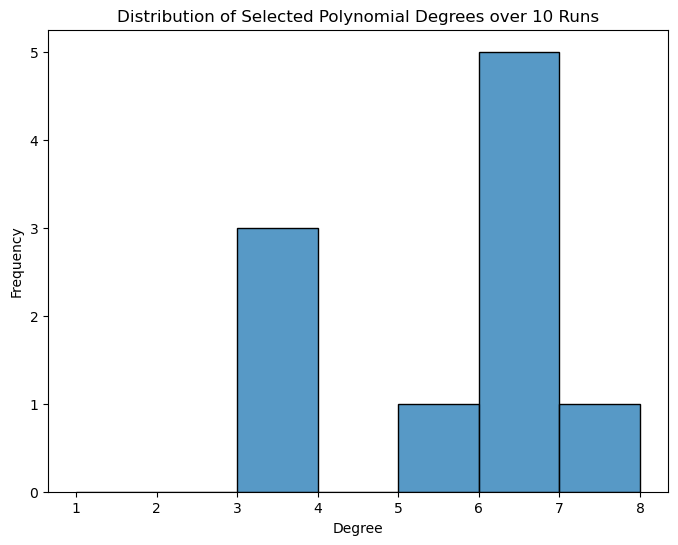

<Figure size 640x480 with 0 Axes>

In [ ]:
#NAO CORRER
# Ciclo de 10 runs, para encontrar o melhor grau 
selected_degrees = []
for i in range(10):
    X_train_sample, _, y_train_sample, _ = train_test_split(X_train_final, y_train_final, train_size=0.01, random_state=i)
    X_val_sample, _, y_val_sample, _ = train_test_split(X_val_final,y_val_final, train_size=0.01, random_state=i)
    best_model, _ = validate_poly_regression(X_train_sample, y_train_sample, X_val_final, y_val_final, degrees=range(1,9))
    best_degree = best_model.named_steps['poly'].degree 
    selected_degrees.append(best_degree)
    
 
# Plot distribuição
plt.figure(figsize=(8,6))
sns.histplot(selected_degrees, bins=range(1,9), kde=False)
plt.title("Distribution of Selected Polynomial Degrees over 10 Runs")
plt.xlabel("Degree")
plt.ylabel("Frequency")
plt.show()
plt.savefig('degree_distribution.pdf') 

In [ ]:
#NAO CORRER
#Previsão com o conjunto de validação
poly = PolynomialFeatures(degree=3, include_bias=False)
pipeline_poly = Pipeline([
    ('poly', poly),
    ('scaler', StandardScaler()),
    ('regressor', RidgeCV(alphas=[0.1, 1.0, 10.0]))  
])
pipeline_poly.fit(X_train_final, y_train_final)

# Predict no test split interno
y_pred_poly = pipeline_poly.predict(X_val_final)
rmse_poly = np.sqrt(mean_squared_error(y_pred_poly, y_val_final))
print(f"Polynomial RMSE: {rmse_poly:.6f}")

Polynomial RMSE: 1.397675


Baseline RMSE: 1.405752
Polynomial RMSE: 1.397675
0.008077255898452984


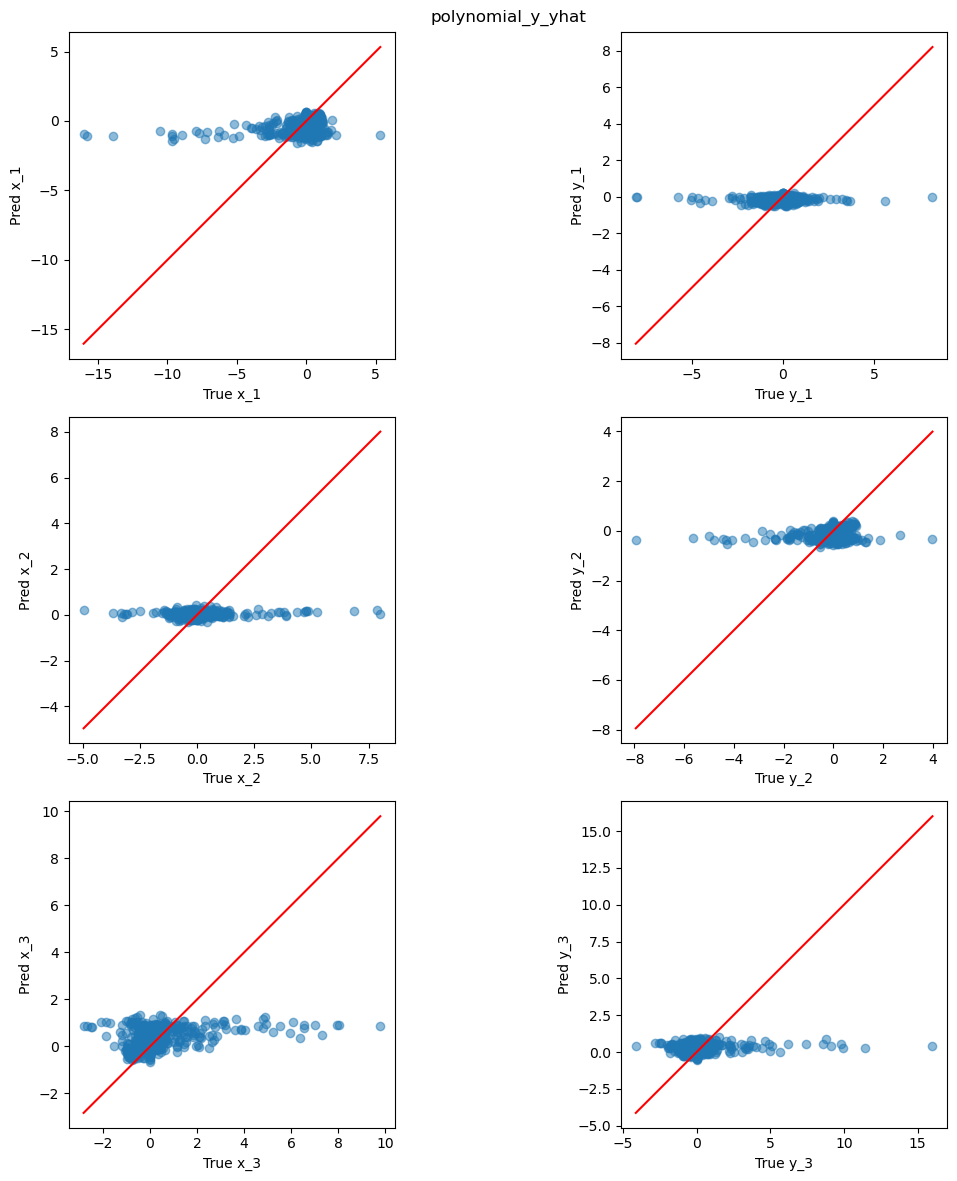

<Figure size 640x480 with 0 Axes>

In [ ]:
#NAO CORRER
# Comparação RMSE
print(f"Baseline RMSE: {rmse_test:.6f}")  
print(f"Polynomial RMSE: {rmse_poly:.6f}")
print(abs(rmse_poly - rmse_test))

plot(y_val_final, y_pred_poly, plot_title="polynomial_y_yhat")

In [ ]:
#NAO CORRER
#Ficheiro para submeter
predictions_poly = pipeline_poly.predict(X_test)
labels = ['x_1', 'y_1', 'x_2', 'y_2', 'x_3', 'y_3']
predictions_df_poly = pd.DataFrame(predictions_poly, columns=labels)
predictions_df_poly.insert(0, 'id', range(len(predictions_poly)))
predictions_df_poly.to_csv('polynomial_submission.csv', index=False)

##**Task 3**

###Task 3.1 - Removing variables

Objetivo: ver relações lineares entre features → eliminar redundantes.

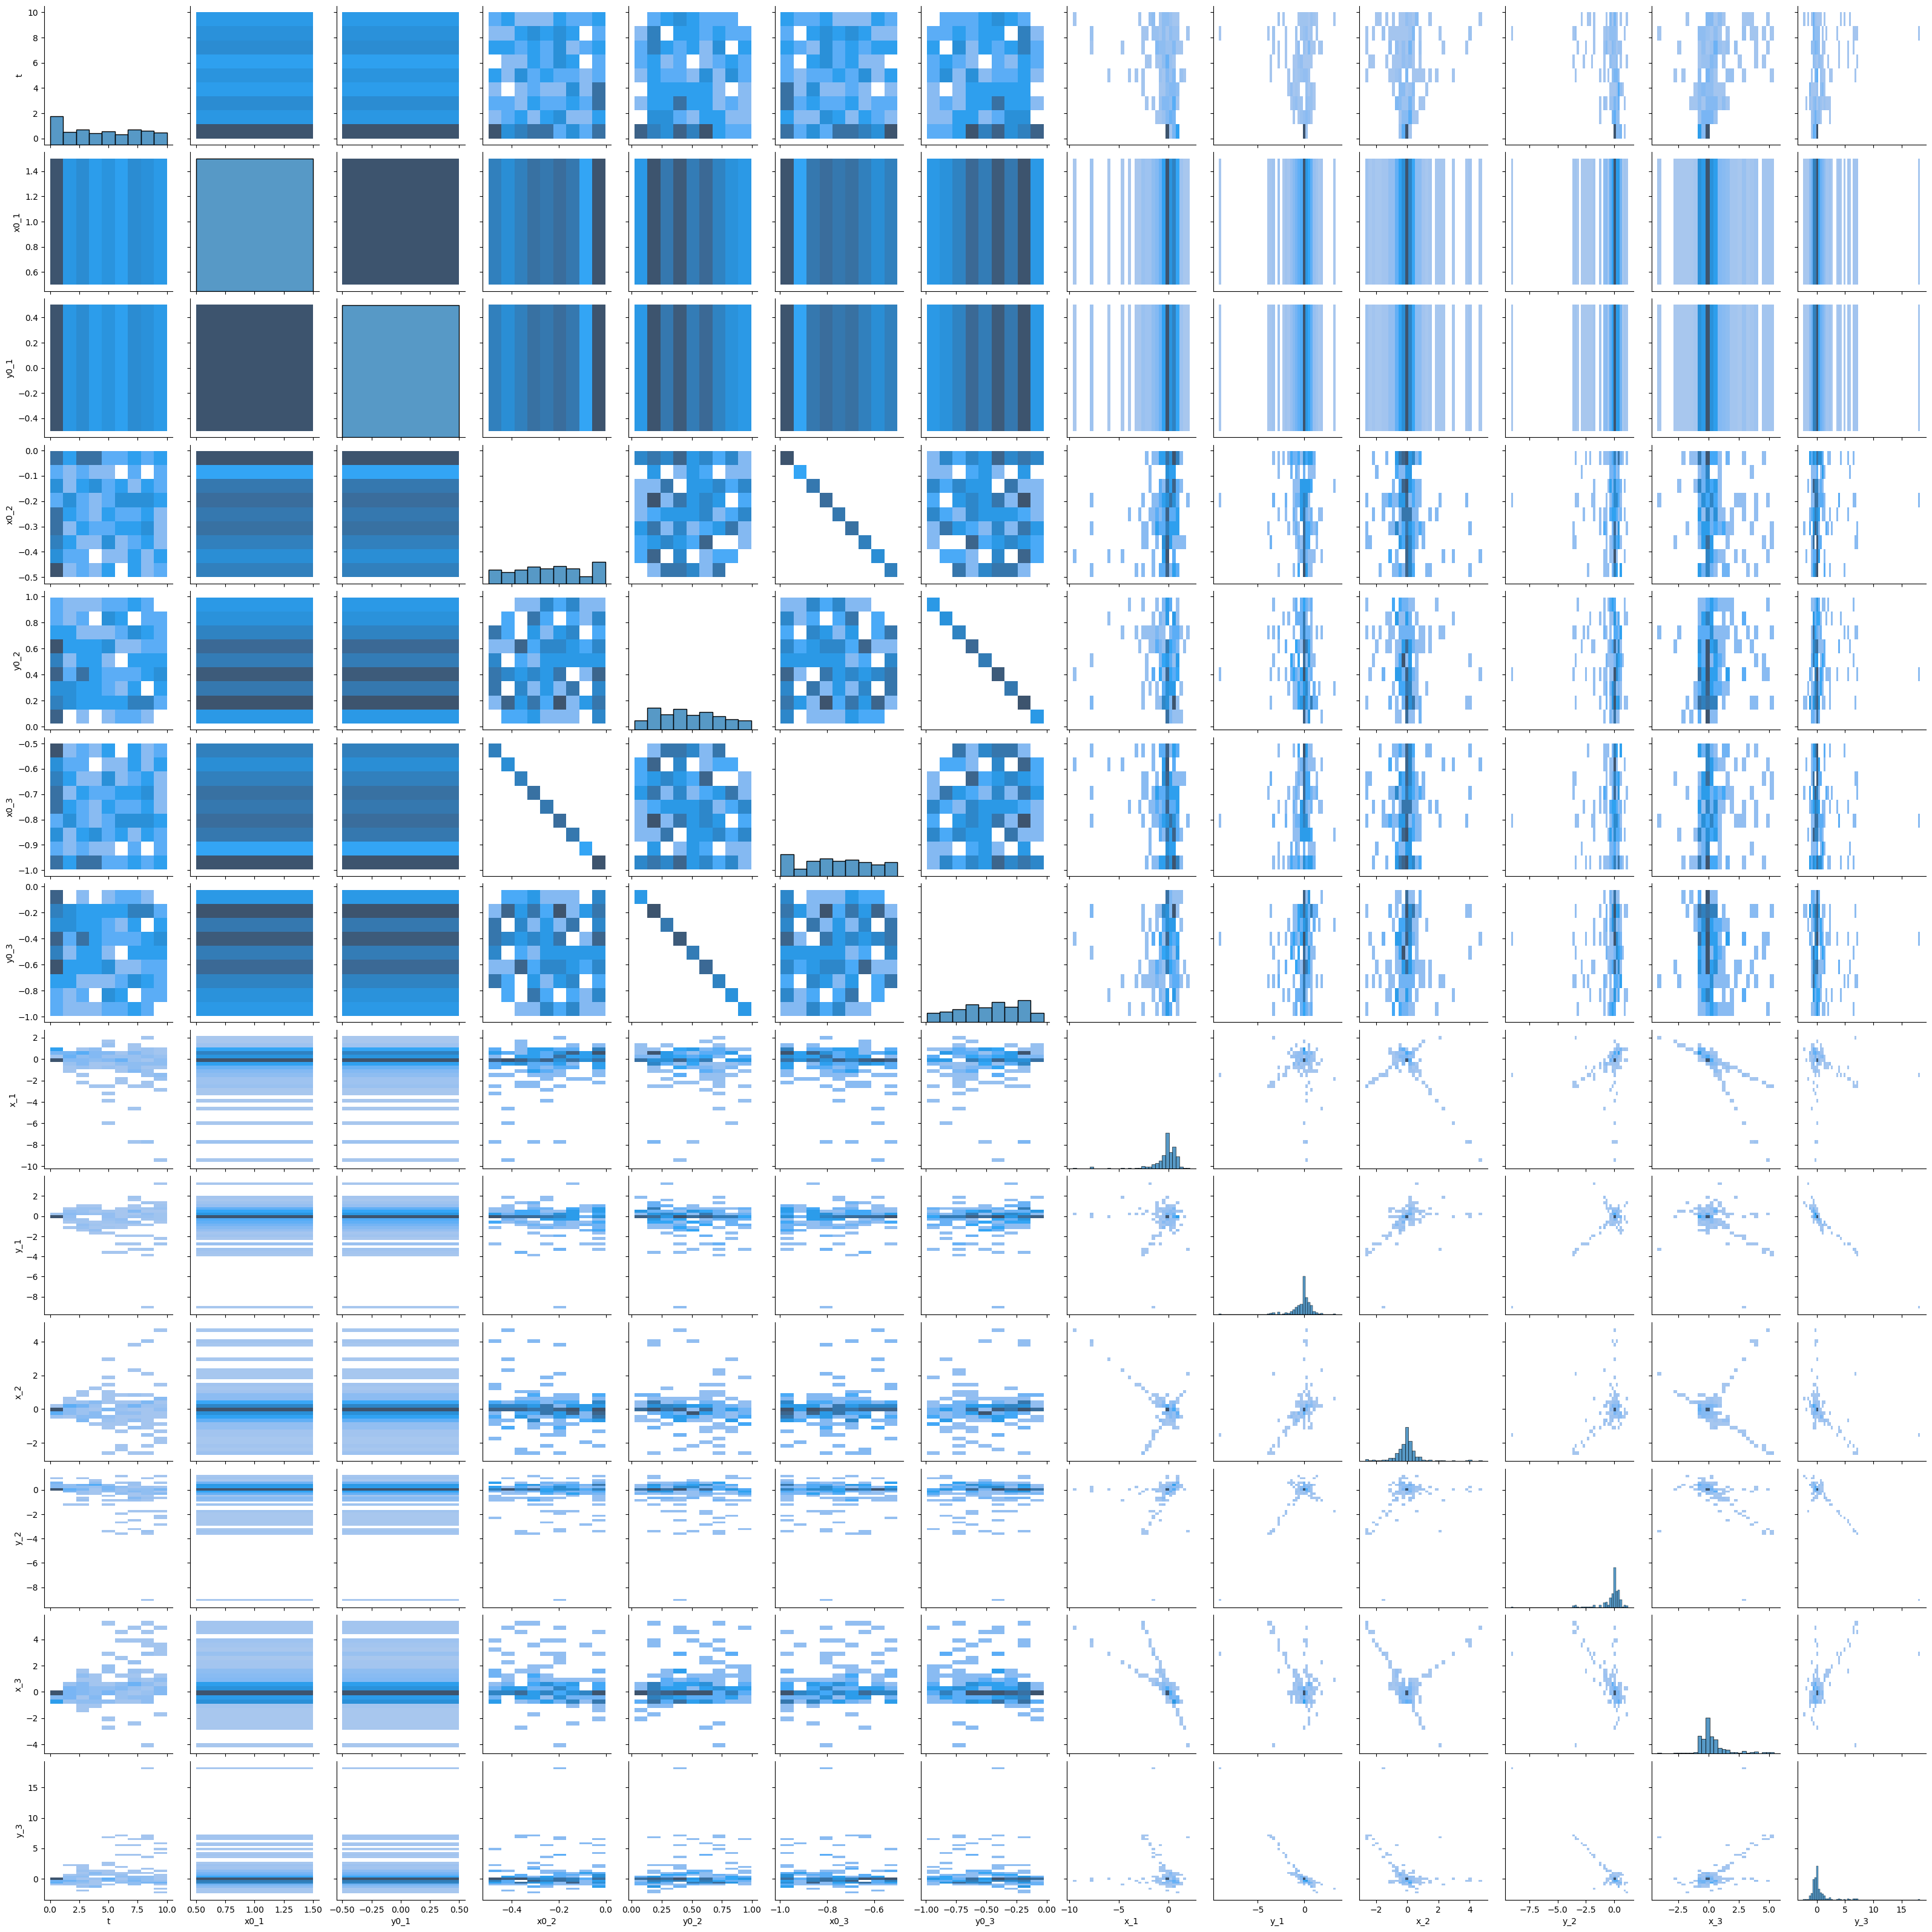

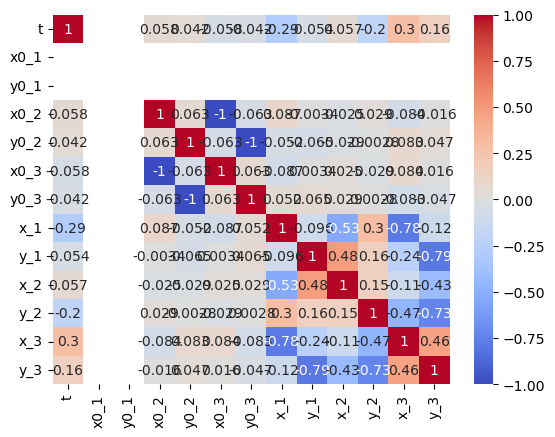

y_3  y_1    0.793223
y_1  y_3    0.793223
x_1  x_3    0.782195
x_3  x_1    0.782195
y_2  y_3    0.728916
y_3  y_2    0.728916
x_1  x_2    0.533176
x_2  x_1    0.533176
     y_1    0.483966
y_1  x_2    0.483966
y_2  x_3    0.465293
x_3  y_2    0.465293
y_3  x_3    0.455768
x_3  y_3    0.455768
y_3  x_2    0.429490
x_2  y_3    0.429490
y_2  x_1    0.300783
x_1  y_2    0.300783
t    x_3    0.296169
x_3  t      0.296169
dtype: float64


<Figure size 640x480 with 0 Axes>

In [ ]:
# Pairplot (gráfico de dispersão)
sns.pairplot(X_train_joined[feature_cols + target_cols].sample(200), kind="hist")
plt.show()
plt.savefig('feature_pairplot.pdf')

# Matriz de correlação 
corr = X_train_joined[feature_cols + target_cols].corr()
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.show()
plt.savefig('correlation_heatmap.pdf')
corr_unstacked = corr.abs().unstack().sort_values(ascending=False)
corr_unstacked = corr_unstacked[corr_unstacked < 1.0]
print(corr_unstacked.head(20))  # top 20 correlações

###Task 3.2 - Evaluation of Variable Reduction

RMSE sem x0_3: 1.405755


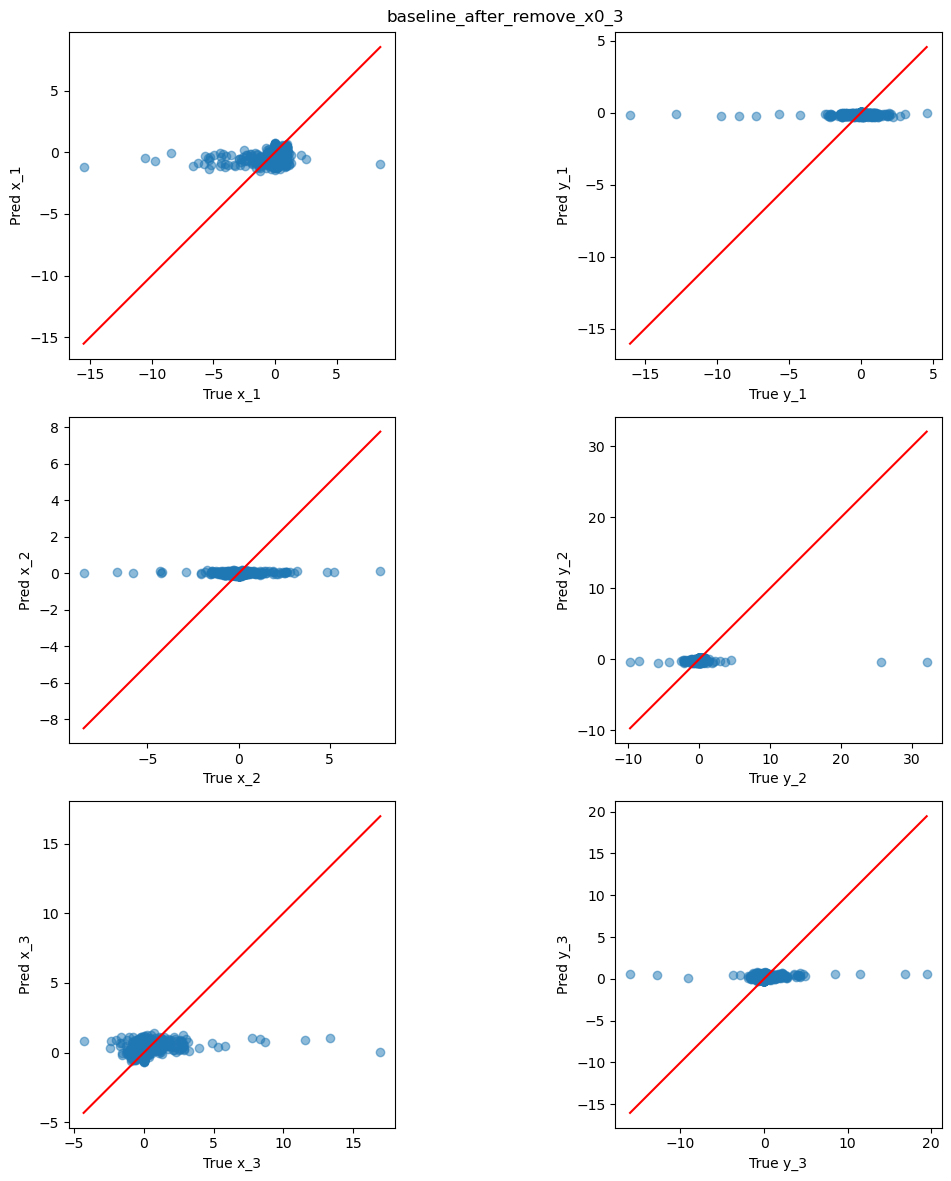

RMSE sem y0_2: 1.405754


<Figure size 640x480 with 0 Axes>

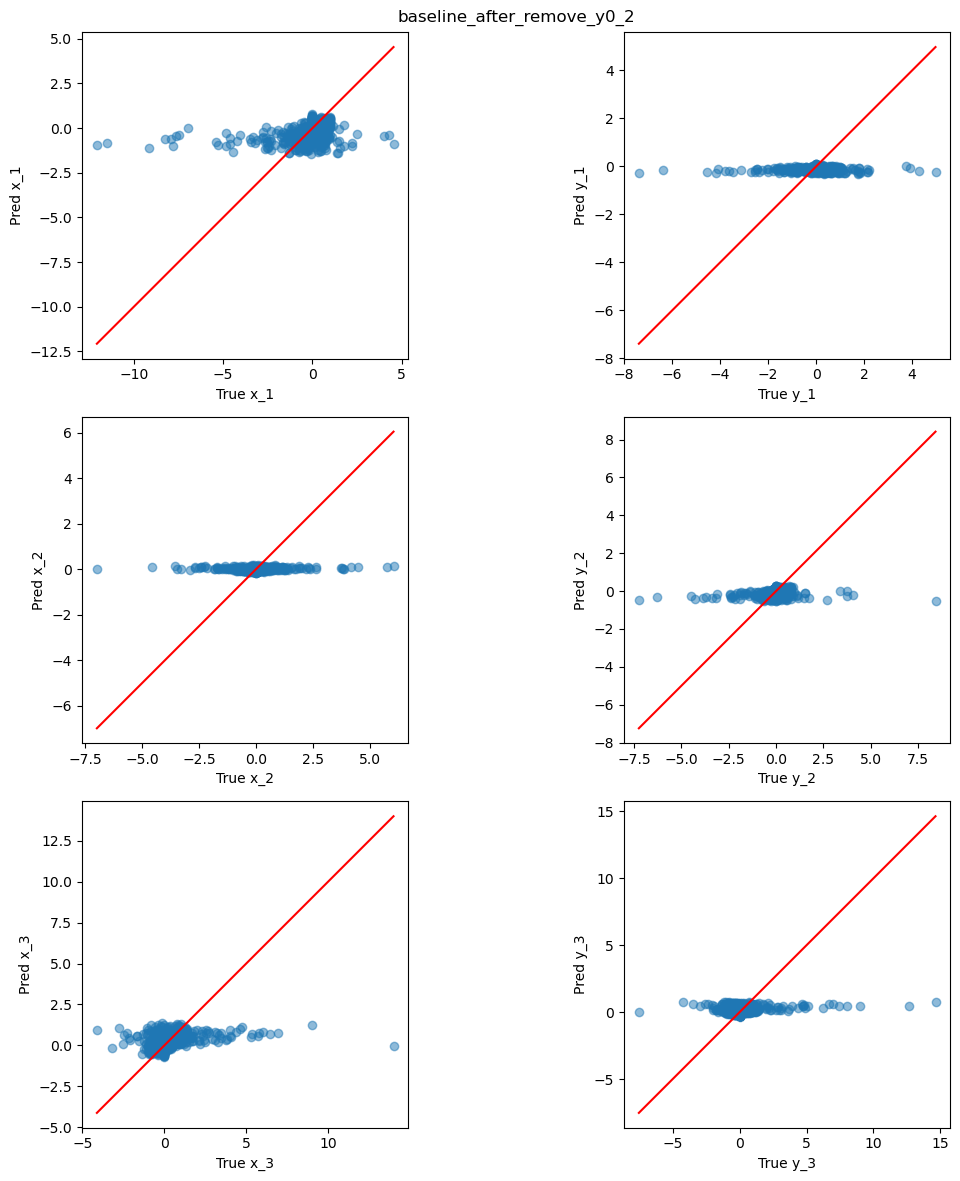

RMSE sem y0_3: 1.405754


<Figure size 640x480 with 0 Axes>

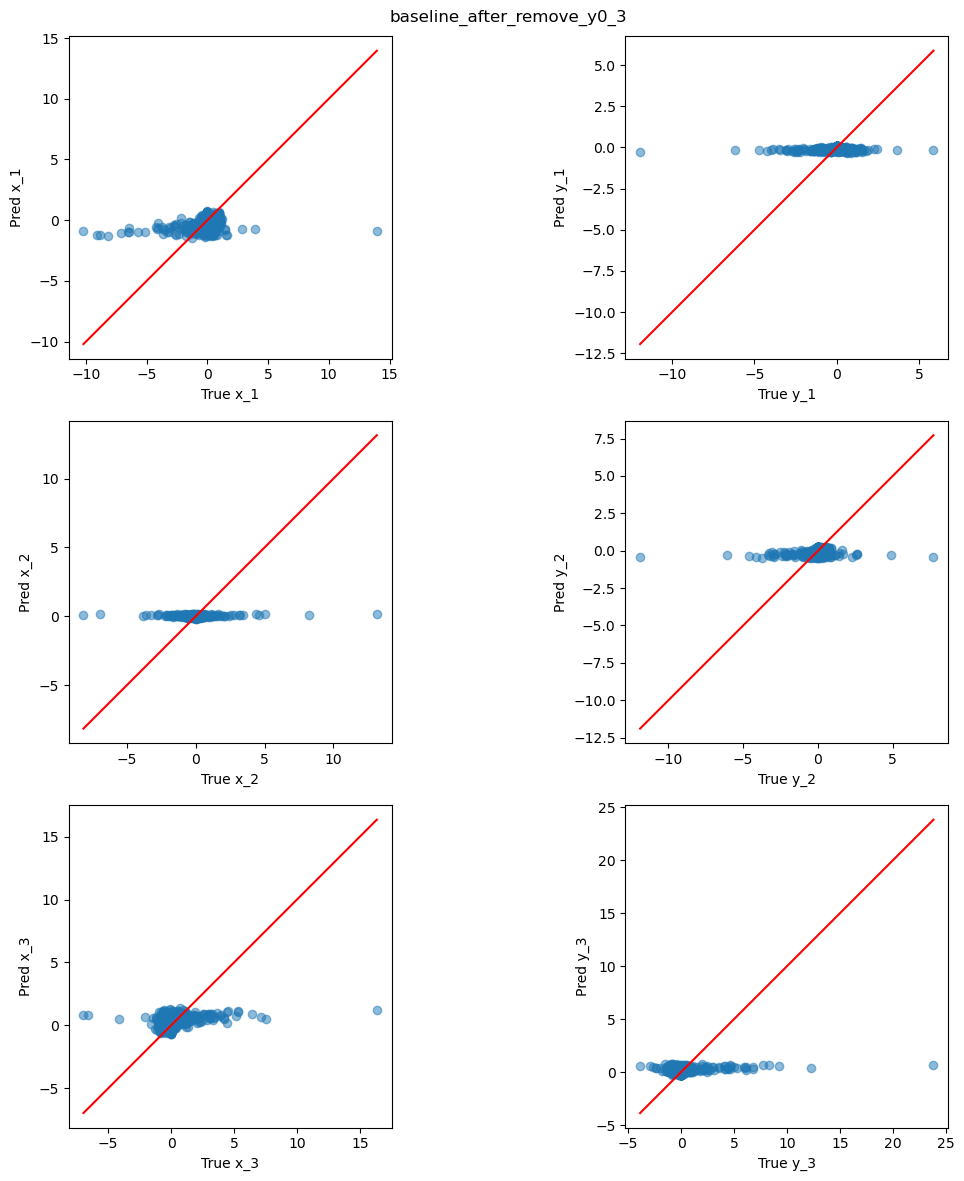

Original Baseline RMSE: 1.405752
RMSEs remoções: {'x0_3': 1.4057554337570362, 'y0_2': 1.4057543501097312, 'y0_3': 1.4057541007429897}


<Figure size 640x480 with 0 Axes>

In [28]:
# Função para testar remoção
def test_feature_removal(feature_to_remove, X_train, y_train, X_test, y_test):
    reduced_cols = [col for col in feature_cols if col != feature_to_remove]
    X_train_red = X_train[reduced_cols]
    X_test_red = X_test[reduced_cols]
    
    pipeline_red = Pipeline([
        ('scaler', StandardScaler()),
        ('regressor', LinearRegression())
    ])
    pipeline_red.fit(X_train_red, y_train)
    
    y_pred_red = pipeline_red.predict(X_test_red)
    rmse_red = np.sqrt(mean_squared_error(y_pred_red, y_test))
    print(f"RMSE sem {feature_to_remove}: {rmse_red:.6f}")
    
    # Plot para comparação
    plot(y_test, y_pred_red, plot_title=f"baseline_after_remove_{feature_to_remove}")
    
    return rmse_red, pipeline_red

# Teste remoções sequenciais 
candidates_to_remove = ['x0_3', 'y0_2', 'y0_3']  
rmses_removal = {}
current_cols = feature_cols.copy()
for feat in candidates_to_remove:
    rmse, _ = test_feature_removal(feat, X_train_final, y_train_final, X_val_final, y_val_final)
    rmses_removal[feat] = rmse

print(f"Original Baseline RMSE: {rmse_test:.6f}")
print("RMSEs remoções:", rmses_removal)

In [20]:
reduced_feature_cols = ['t','x0_1','y0_1','x0_2','y0_2','x0_3'] #sem o y_03
X_train_red = X_train_final[reduced_feature_cols]
X_val_red = X_val_final[reduced_feature_cols]

In [ ]:
#NAO CORRER
# Melhor grau sem y0_3 (escolhido)
best_model_red, best_rmse_red = validate_poly_regression(X_train_red, y_train_final, X_val_red, y_val_final, regressor=RidgeCV(alphas=[0.1, 1.0, 10.0]), degrees=range(1,9))

Degree 1: = 7
1: RMSE = 1.667537
Degree 2: = 35
2: RMSE = 1.662861
Degree 3: = 119
3: RMSE = 1.658829
Degree 4: = 329
4: RMSE = 1.660366
Degree 5: = 791
5: RMSE = 1.657739
Degree 6: = 1715
6: RMSE = 1.652990
Degree 7: = 3431
7: RMSE = 1.651198
Degree 8: = 6434
8: RMSE = 1.651295
Best degree: 7 with RMSE: 1.651198


Poly RMSE: 1.397675
Reduced Poly RMSE: 1.389091


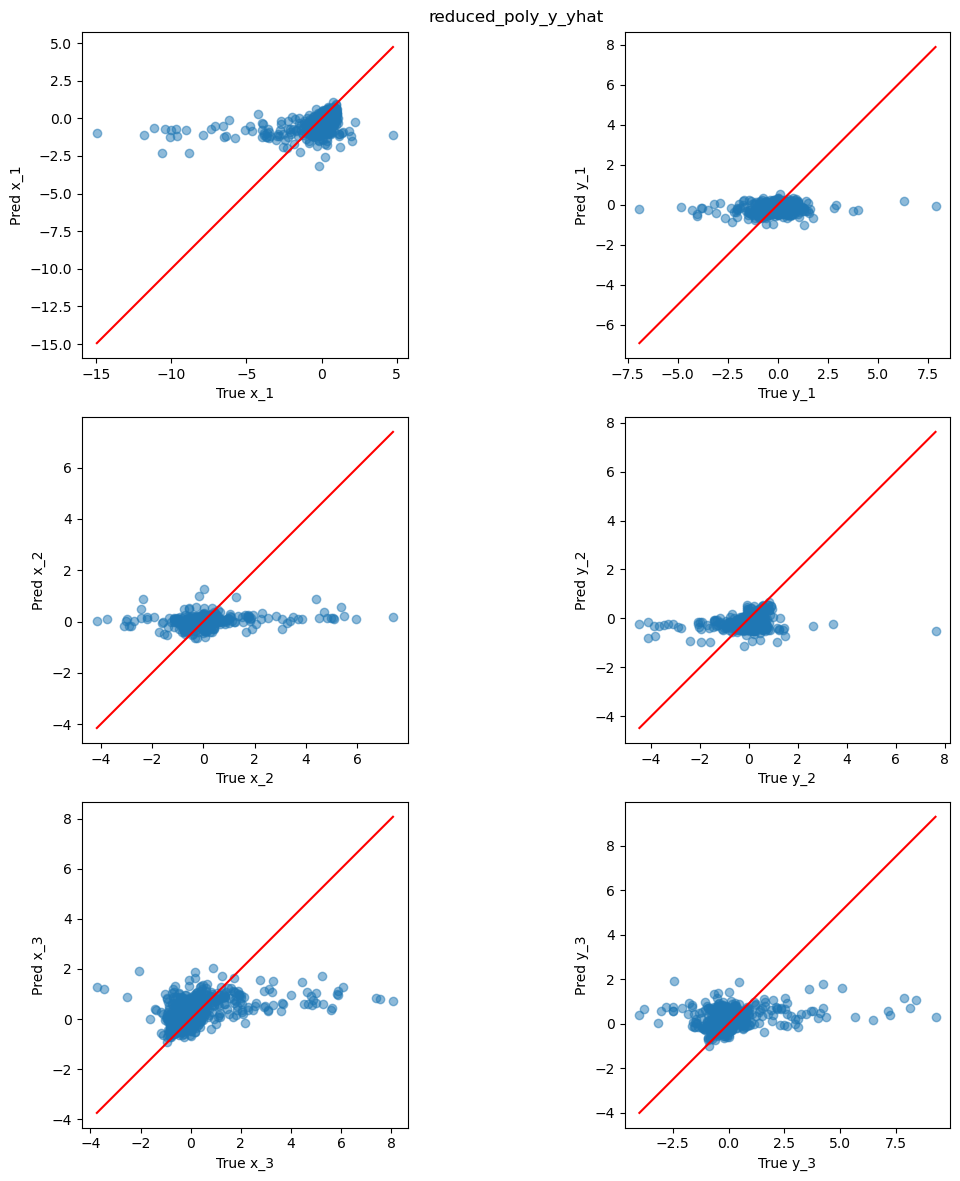

<Figure size 640x480 with 0 Axes>

In [ ]:
#NAO CORRER
#Previsão com o conjunto de validação
poly = PolynomialFeatures(degree=6, include_bias=False)
regressor = RidgeCV(alphas=[0.1, 1.0, 10.0])  
pipeline_poly_red = Pipeline([
    ('poly', poly),
    ('scaler', StandardScaler()),
    ('regressor', regressor)
])

pipeline_poly_red.fit(X_train_red, y_train_final)
y_pred_poly_red = pipeline_poly_red.predict(X_val_red)
rmse_poly_red = np.sqrt(mean_squared_error(y_pred_poly_red, y_val_final))

# Comparação
rmse_poly =1.397675
print(f"Poly RMSE: {rmse_poly:.6f}")  
print(f"Reduced Poly RMSE: {rmse_poly_red:.6f}")

# Plot
plot(y_val_final, y_pred_poly_red, plot_title="reduced_poly_y_yhat")

In [77]:
#NAO CORRER
# Submissão 
X_test_reduced = X_test_df[reduced_feature_cols]  
predictions_red = pipeline_poly_red.predict(X_test_reduced)
predictions_df_red = pd.DataFrame(predictions_red, columns=target_cols)
predictions_df_red.insert(0, 'id', range(len(predictions_red)))
predictions_df_red.to_csv('reduced_polynomial_submission.csv', index=False)

###Task 3.3 - Adding Variables

In [32]:
# Função para novas features 
def add_custom_features(X):
    new_X = X.copy()
    #Calculo da distância entre os corpos
    new_X['dist_12'] = np.sqrt((X['x0_1'] - X['x0_2'])**2 + (X['y0_1'] - X['y0_2'])**2)
    new_X['dist_13'] = np.sqrt((X['x0_1'] - X['x0_3'])**2 + (X['y0_1'] - X['y0_3'])**2)
    new_X['dist_23'] = np.sqrt((X['x0_2'] - X['x0_3'])**2 + (X['y0_2'] - X['y0_3'])**2)
   
    # Calcula o inverso da distância entre corpos: no problema de três corpos, a força gravitacional entre dois corpos é inversamente proporcional à distância 
    new_X['inv_dist_12'] = 1 / (new_X['dist_12'] + 1e-6)  # Avoid div0
    new_X['inv_dist_13'] = 1 / (new_X['dist_13'] + 1e-6)
    new_X['inv_dist_23'] = 1 / (new_X['dist_23'] + 1e-6)
    # Energia potencial (assume G=1, massas=1 para simplicidade; soma inversos das distâncias)
    new_X['potential_energy'] = - (1 / (new_X['dist_12'] + 1e-6) + 1 / (new_X['dist_13'] + 1e-6) + 1 / (new_X['dist_23'] + 1e-6))
    # Vetores 
    vec12_x = X['x0_2'] - X['x0_1']
    vec12_y = X['y0_2'] - X['y0_1']
    vec13_x = X['x0_3'] - X['x0_1']
    vec13_y = X['y0_3'] - X['y0_1']
    vec23_x = X['x0_3'] - X['x0_2']
    vec23_y = X['y0_3'] - X['y0_2']
    # Ângulo entre vetores
    new_X['angle_1_23'] = np.arctan2(vec12_y, vec12_x) - np.arctan2(vec13_y, vec13_x)
    new_X['angle_2_13'] = np.arctan2(vec12_y, vec12_x) - np.arctan2(vec23_y, vec23_x)
    new_X['angle_3_12'] = np.arctan2(vec13_y, vec13_x) - np.arctan2(vec23_y, vec23_x)
    
    return new_X

Augmented Baseline RMSE: 1.404318


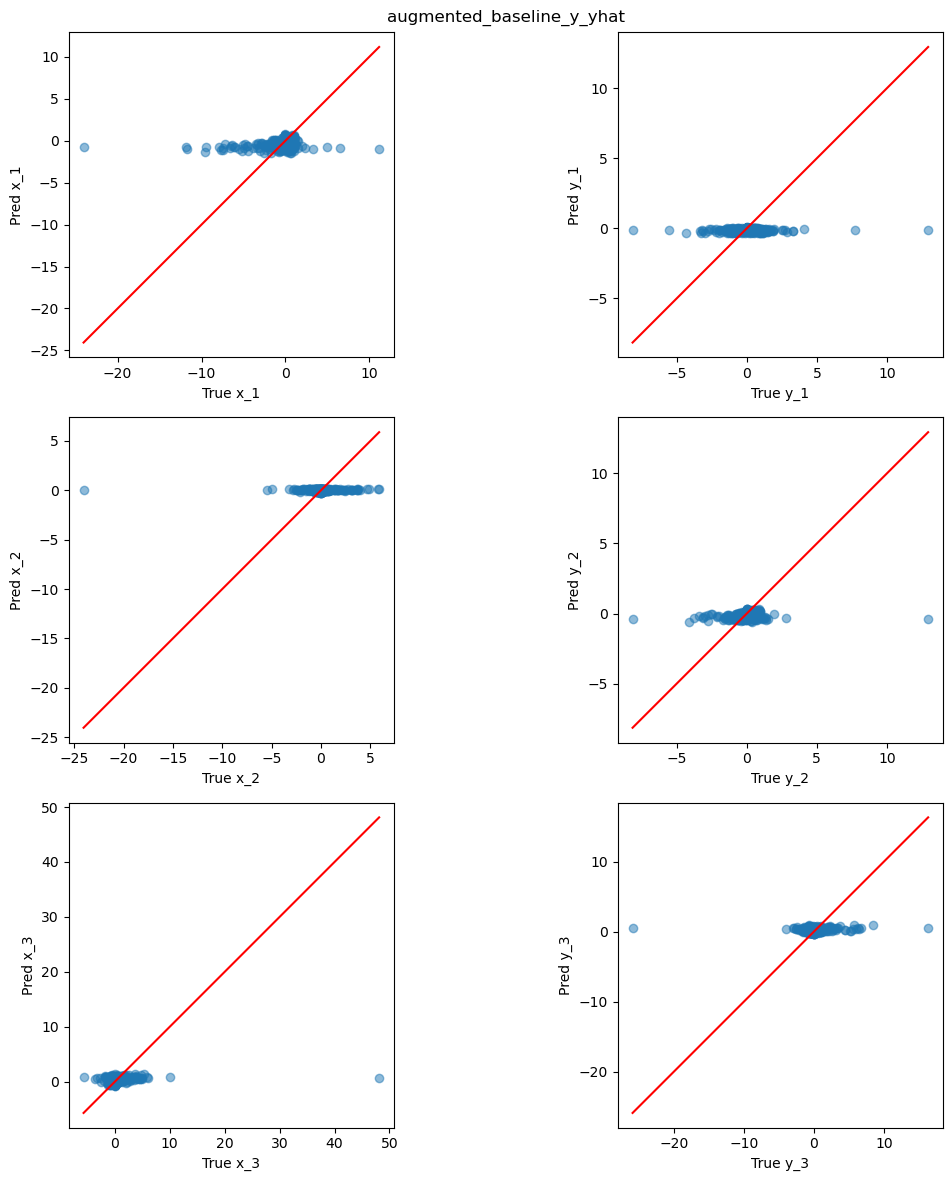

<Figure size 640x480 with 0 Axes>

In [33]:
#Teste1 para descobrir as melhores features para adicionar
X_train_joined_aug = add_custom_features(X_train_joined)
feature_cols_aug =  feature_cols + ['dist_12', 'dist_13', 'dist_23']
X_train_aug = X_train_joined_aug.loc[X_train_split.index, feature_cols_aug]  
X_val_aug = X_train_joined_aug.loc[X_val_split.index, feature_cols_aug]

# Testar com baseline 
pipeline_aug_base = Pipeline([
    ('scaler', StandardScaler()),
    ('regressor', LinearRegression())
])
pipeline_aug_base.fit(X_train_aug, y_train_final)
y_pred_aug_base = pipeline_aug_base.predict(X_val_aug)
rmse_aug_base = np.sqrt(mean_squared_error(y_pred_aug_base, y_val_final))
print(f"Augmented Baseline RMSE: {rmse_aug_base:.6f}")

# Plot
plot(y_val_final, y_pred_aug_base, plot_title="augmented_baseline_y_yhat")

Augmented Baseline RMSE: 1.404430


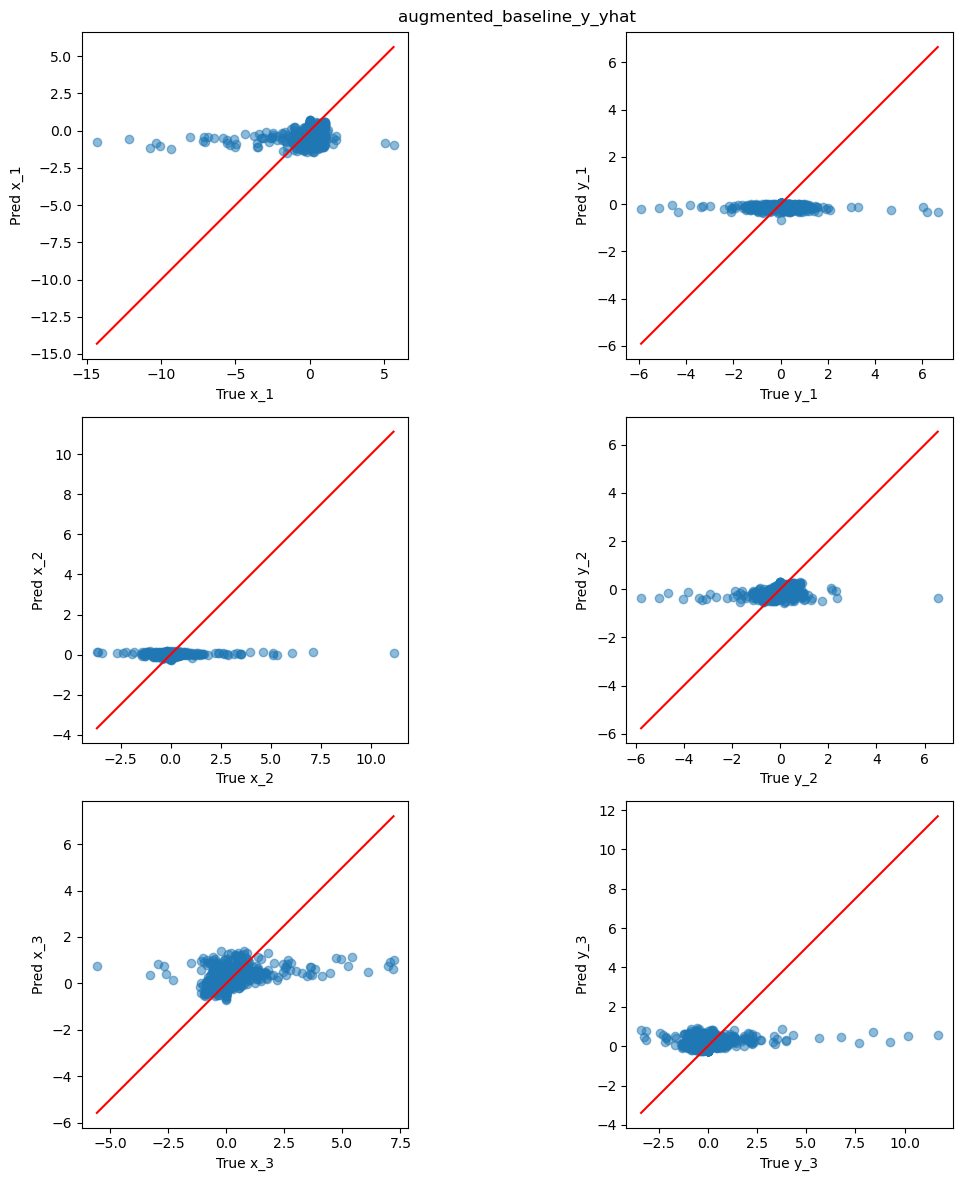

<Figure size 640x480 with 0 Axes>

In [35]:
#Teste2 para descobrir as melhores features para adicionar
X_train_joined_aug = add_custom_features(X_train_joined)
feature_cols_aug = feature_cols + [ 'dist_12', 'dist_13', 'dist_23','potential_energy']
X_train_aug = X_train_joined_aug.loc[X_train_split.index, feature_cols_aug]  
X_val_aug = X_train_joined_aug.loc[X_val_split.index, feature_cols_aug]

pipeline_aum_base = Pipeline([
    ('scaler', StandardScaler()),
    ('regressor', LinearRegression())
])
pipeline_aug_base.fit(X_train_aug, y_train_final)
y_pred_aug_base = pipeline_aug_base.predict(X_val_aug)
rmse_aug_base = np.sqrt(mean_squared_error(y_pred_aug_base, y_val_final))
print(f"Augmented Baseline RMSE: {rmse_aug_base:.6f}")

# Plot
plot(y_val_final, y_pred_aug_base, plot_title="augmented_baseline_y_yhat")

Augmented Baseline RMSE: 1.403281


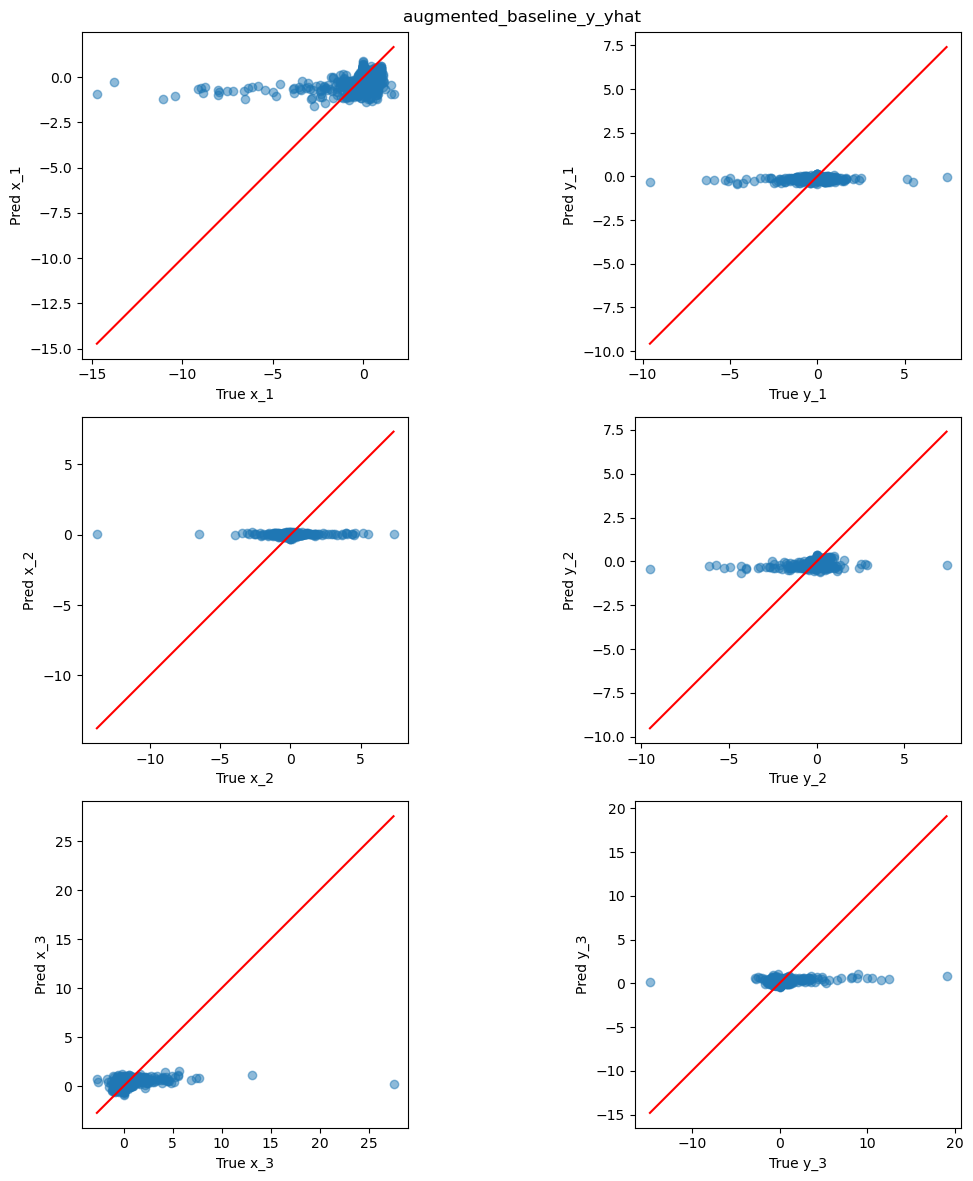

<Figure size 640x480 with 0 Axes>

In [36]:
#Teste3 para descobrir as melhores features para adicionar
X_train_joined_aug = add_custom_features(X_train_joined)
feature_cols_aug = feature_cols + ['dist_12', 'dist_13', 'dist_23','inv_dist_12','inv_dist_13','inv_dist_23']
X_train_aug = X_train_joined_aug.loc[X_train_split.index, feature_cols_aug]  
X_val_aug = X_train_joined_aug.loc[X_val_split.index, feature_cols_aug]

pipeline_aug_base = Pipeline([
    ('scaler', StandardScaler()),
    ('regressor', LinearRegression())
])
pipeline_aug_base.fit(X_train_aug, y_train_final)
y_pred_aug_base = pipeline_aug_base.predict(X_val_aug)
rmse_aug_base = np.sqrt(mean_squared_error(y_pred_aug_base, y_val_final))
print(f"Augmented Baseline RMSE: {rmse_aug_base:.6f}")

# Plot
plot(y_val_final, y_pred_aug_base, plot_title="augmented_baseline_y_yhat")

Augmented Baseline RMSE: 1.404629


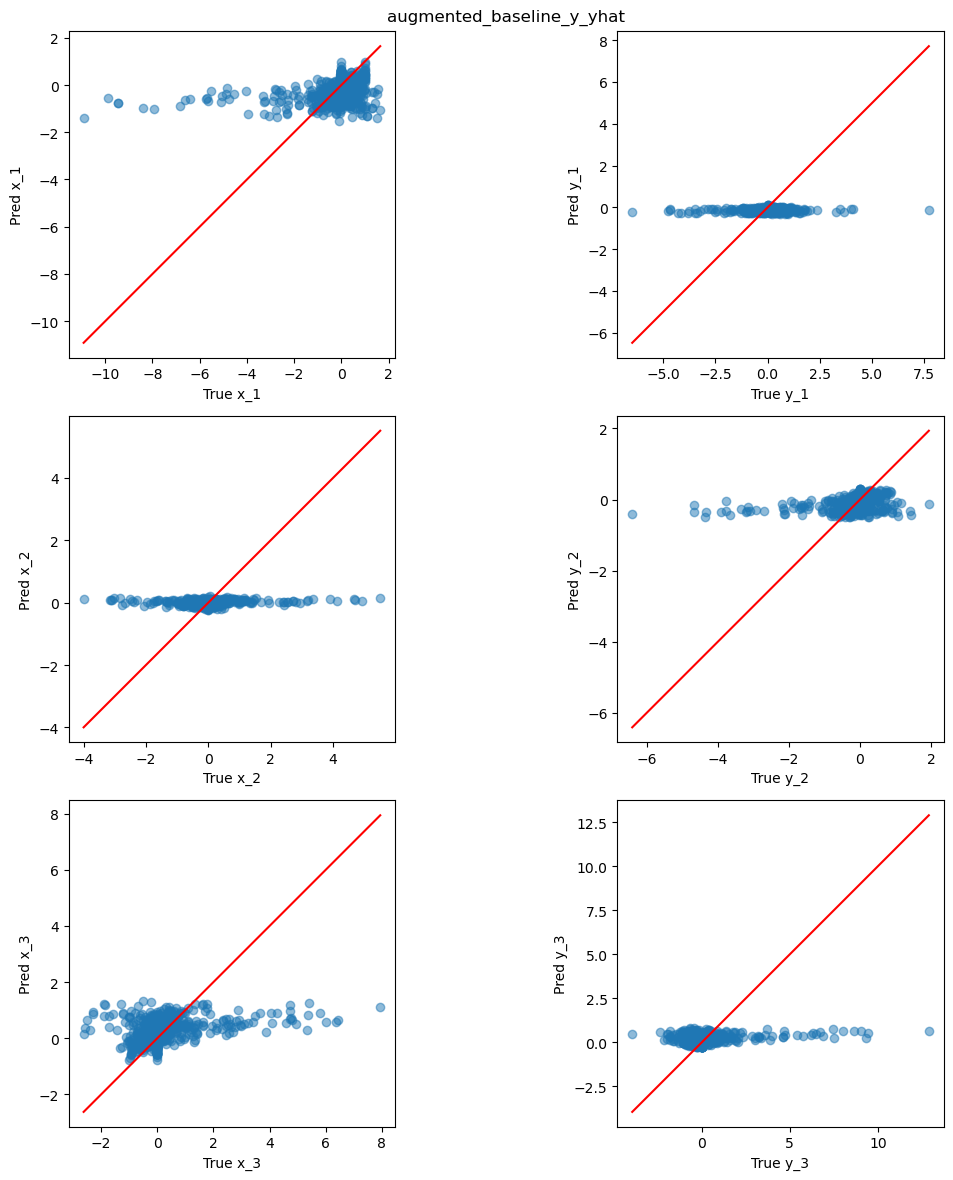

<Figure size 640x480 with 0 Axes>

In [38]:
#Teste4 para descobrir as melhores features para adicionar
X_train_joined_aug = add_custom_features(X_train_joined)
feature_cols_aug = feature_cols + ['angle_1_23','angle_2_13','angle_3_12']
X_train_aug = X_train_joined_aug.loc[X_train_split.index, feature_cols_aug]  
X_val_aug = X_train_joined_aug.loc[X_val_split.index, feature_cols_aug]

pipeline_aug_base = Pipeline([
    ('scaler', StandardScaler()),
    ('regressor', LinearRegression())
])
pipeline_aug_base.fit(X_train_aug, y_train_final)
y_pred_aug_base = pipeline_aug_base.predict(X_val_aug)
rmse_aug_base = np.sqrt(mean_squared_error(y_pred_aug_base, y_val_final))
print(f"Augmented Baseline RMSE: {rmse_aug_base:.6f}")

# Plot
plot(y_val_final, y_pred_aug_base, plot_title="augmented_baseline_y_yhat")

In [76]:
# Função para novas features escolhids
def add_custom_features1(X):
    new_X = X.copy()
    #Calculo da distância entre os corpos
    new_X['dist_12'] = np.sqrt((X['x0_1'] - X['x0_2'])**2 + (X['y0_1'] - X['y0_2'])**2)
    new_X['dist_13'] = np.sqrt((X['x0_1'] - X['x0_3'])**2 + (X['y0_1'] - X['y0_3'])**2)
    new_X['dist_23'] = np.sqrt((X['x0_2'] - X['x0_3'])**2 + (X['y0_2'] - X['y0_3'])**2)

    return new_X

###Task 3.4 - Evaluation of Variable Augmentation

In [74]:
#Função regressão linear com transformer
def validate_poly_regression_aug(X_train, y_train, X_val, y_val, regressor=None, degrees=range(1,6), max_features=None):

    X_train_sample, _, y_train_sample, _ = train_test_split(X_train, y_train, train_size=0.01, random_state=42)
    X_val_sample, _, y_val_sample, _ = train_test_split(X_val ,y_val, train_size=0.01, random_state=42)

    custom_transformer = FunctionTransformer(add_custom_features1) 
    best_rmse = float('inf')
    rmses = []
    best_model = None
    best_degree = None

    for degree in degrees:
        # ColumnTransformer: aplica custom + poly em todas
        preprocessor = ColumnTransformer(
            transformers=[
                ('custom', custom_transformer, X_train_sample.columns), 
            ], remainder='passthrough')
        
        pipeline = Pipeline([
            ('preprocessor', preprocessor),
            ('poly', PolynomialFeatures(degree=degree, include_bias=False)),
            ('scaler', StandardScaler()),
            ('regressor', RidgeCV(alphas=[0.1, 1.0, 10.0]))
        ])
        
        pipeline.fit(X_train_sample, y_train_sample)
        n_features = pipeline.named_steps['poly'].n_output_features_
        print(f"Degree {degree}: = {n_features}")
        
        y_pred_poly = pipeline.predict(X_val_sample)
        rmse_val = np.sqrt(mean_squared_error(y_val_sample, y_pred_poly))
        rmses.append(rmse_val)
        print(f"{degree}: RMSE = {rmse_val:.6f}")
        
        if rmse_val < best_rmse:
            best_rmse = rmse_val
            best_model = pipeline
            best_degree = degree

    print(f"Best degree: {best_degree} with RMSE: {best_rmse:.6f}")
    
    return best_model, best_rmse

In [77]:
#NAO CORRER
#Melhor grau para novas features
best_model_aug, best_rmse_aug = validate_poly_regression_aug(X_train_final, y_train_final, X_val_final, y_val_final, regressor=RidgeCV(alphas=[0.1,1.0,10.0]), degrees=range(1,6))

Degree 1: = 10
1: RMSE = 1.665532
Degree 2: = 65
2: RMSE = 1.661904
Degree 3: = 285
3: RMSE = 1.660411
Degree 4: = 1000
4: RMSE = 1.657993
Degree 5: = 3002
5: RMSE = 1.654399
Best degree: 5 with RMSE: 1.654399


Augmented Poly RMSE: 1.393233


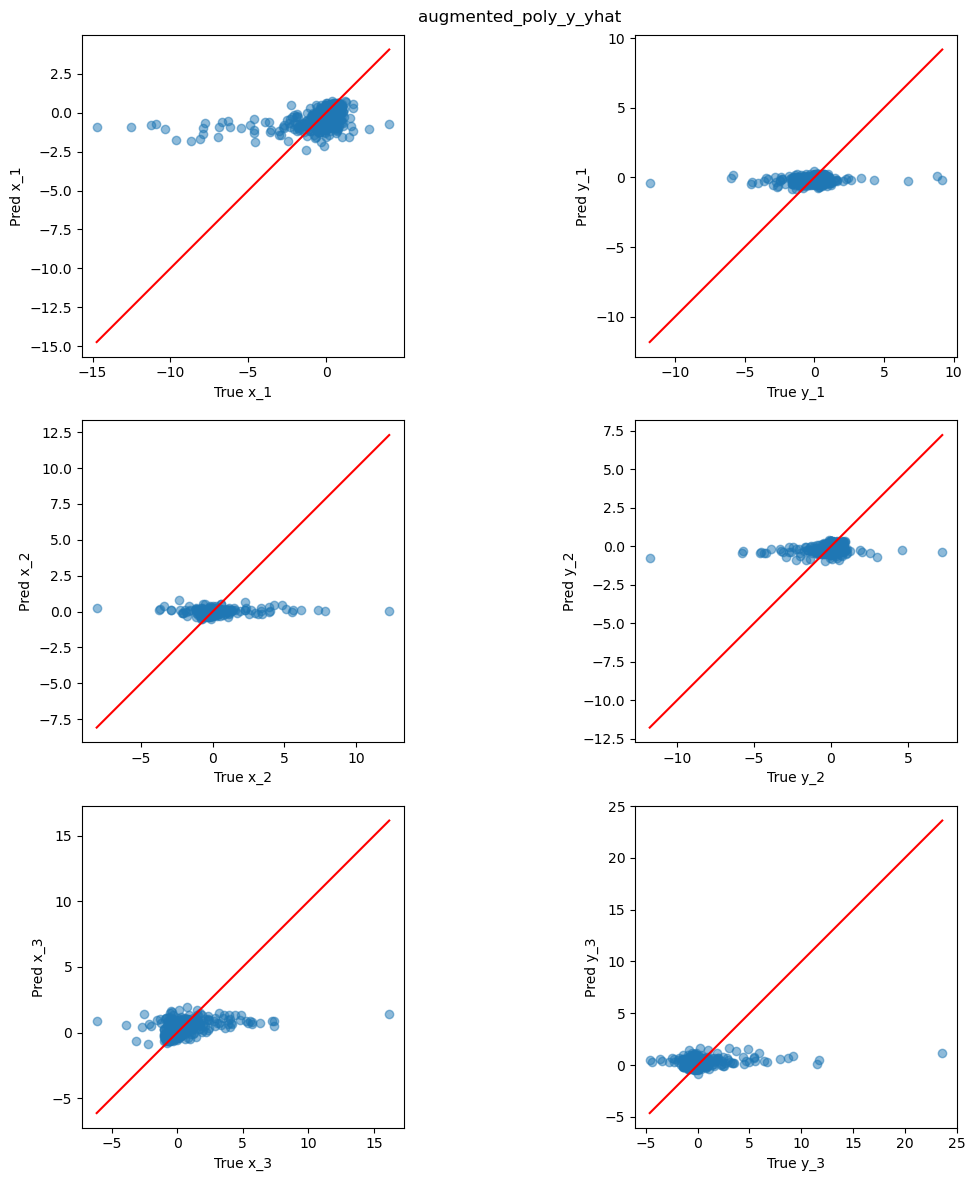

Poly RMSE: 1.397675
Reduced Poly RMSE: 1.389091
Augmented Poly RMSE: 1.393233


<Figure size 640x480 with 0 Axes>

In [78]:
#NAO CORRER
#validar com o conjunto de validação
custom_transformer = FunctionTransformer(add_custom_features1) 

preprocessor = ColumnTransformer(
    transformers=[
    ('custom', custom_transformer, X_train_sample.columns), 
    ], remainder='passthrough')
        
pipeline_poly_aug = Pipeline([
('preprocessor', preprocessor),
('poly', PolynomialFeatures(degree=4, include_bias=False)),
('scaler', StandardScaler()),
('regressor', RidgeCV(alphas=[0.1, 1.0, 10.0]))
])

pipeline_poly_aug.fit(X_train_final, y_train_final)

# Previsão no teste interno
y_pred_aug = pipeline_poly_aug.predict(X_val_final)
rmse_aug = np.sqrt(mean_squared_error(y_pred_aug, y_val_final))
print(f"Augmented Poly RMSE: {rmse_aug:.6f}")


plot(y_val_final, y_pred_aug, plot_title="augmented_poly_y_yhat")

# Comparação
rmse_poly = 1.397675
rmse_poly_red=1.389091
print(f"Poly RMSE: {rmse_poly:.6f}")
print(f"Reduced Poly RMSE: {rmse_poly_red:.6f}")
print(f"Augmented Poly RMSE: {rmse_aug:.6f}")  

In [80]:
X_test_aug = pd.DataFrame()
X_test_aug = add_custom_features1(X_test)
feature_cols_aug = feature_cols + ['dist_12', 'dist_13', 'dist_23']
X_test_aug = X_test_aug[feature_cols_aug]
predictions_aug = pipeline_poly_aug.predict(X_test_aug)
predictions_df_aug = pd.DataFrame(predictions_aug, columns=target_cols)
predictions_df_aug.insert(0, 'id', range(len(predictions_aug)))
predictions_df_aug.to_csv('augmented_polynomial_submission.csv', index=False)

##**Task 4**

##Task 4.1 - Development

In [51]:
def validate_knn_regression(X_train, y_train, X_val, y_val, k=range(1, 30)):
    
    results = {
        'k_values': list(k),
        'rmse': [],
        'train_times': [],
        'infer_times': []
    }
    
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_val_scaled = scaler.transform(X_val)
    
    for current_k in k:
        knn = KNeighborsRegressor(n_neighbors=current_k, metric='euclidean') 
        
        # Medir training time
        start_train = time.time()
        knn.fit(X_train_scaled, y_train)
        end_train = time.time()
        train_time = end_train - start_train
        results['train_times'].append(train_time)
        
        # Medir inference time
        start_infer = time.time()
        y_pred = knn.predict(X_val_scaled)
        end_infer = time.time()
        infer_time = end_infer - start_infer
        results['infer_times'].append(infer_time)
        
        rmse = np.sqrt(mean_squared_error(y_val, y_pred))
        results['rmse'].append(rmse)
    
    return results

In [52]:
results_base = validate_knn_regression(X_train_final, y_train_final, X_val_final, y_val_final)
print(results_base)

{'k_values': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29], 'rmse': [1.7916682904797763, 1.7685049322335347, 1.77067504909854, 1.7536260453049204, 1.7461277155979638, 1.718142080337532, 1.7024680274523623, 1.679580129920203, 1.6645484894703861, 1.6446978417359328, 1.6301109420290625, 1.611920248836533, 1.5960805678841186, 1.5842700914322083, 1.5733760848461946, 1.565381172994679, 1.5585907701763535, 1.552344418016573, 1.544857110175535, 1.5400268947279152, 1.5367517999148979, 1.5335111964477646, 1.5285237385248547, 1.5237212505420523, 1.5204243487967737, 1.5159671806657953, 1.510992032080672, 1.5064639787662661, 1.5035723662828602], 'train_times': [1.565443515777588, 1.5454049110412598, 1.525155782699585, 1.5375399589538574, 1.5265438556671143, 1.5341877937316895, 1.5242540836334229, 1.52158784866333, 1.5342991352081299, 1.5291075706481934, 1.5178303718566895, 1.583136796951294, 1.5714211463928223, 1.5261123180389404, 1.6139

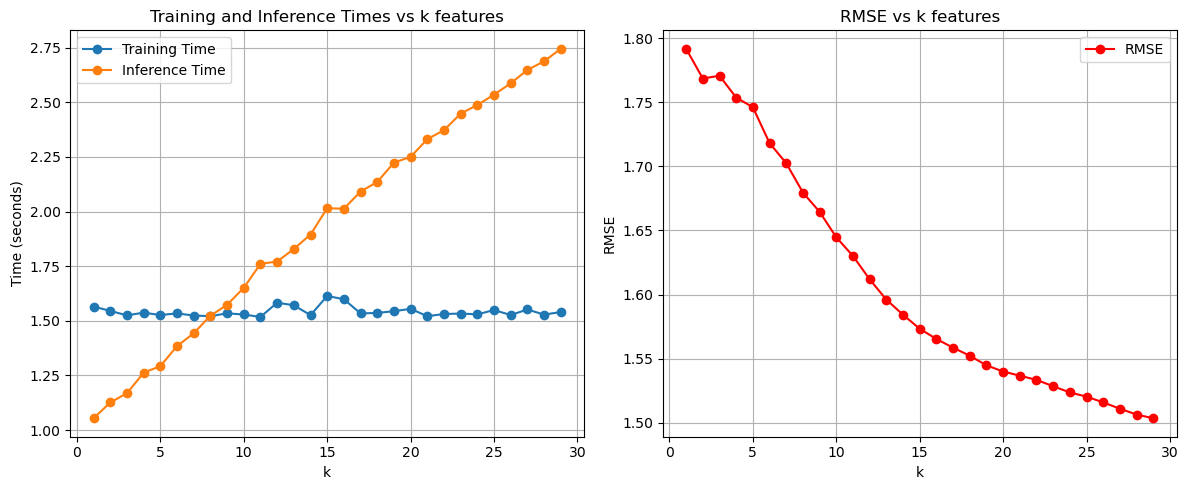

In [53]:
def plot_times_and_rmse(results, title_suffix="", save=True):
  
    k_values = results['k_values']
    
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(k_values, results['train_times'], label='Training Time', marker='o')
    plt.plot(k_values, results['infer_times'], label='Inference Time', marker='o')
    plt.xlabel('k')
    plt.ylabel('Time (seconds)')
    plt.title(f'Training and Inference Times vs k {title_suffix}')
    plt.legend()
    plt.grid(True)
    
    plt.subplot(1, 2, 2)
    plt.plot(k_values, results['rmse'], label='RMSE', marker='o', color='red')
    plt.xlabel('k')
    plt.ylabel('RMSE')
    plt.title(f'RMSE vs k {title_suffix}')
    plt.legend()
    plt.grid(True)
    
    plt.tight_layout()
    if save:
        plt.savefig(f'knn_analysis{title_suffix}.pdf')
    plt.show()

plot_times_and_rmse(results_base, title_suffix="features")

In [54]:
# Encontrar melhor k base
best_k_base = results_base['k_values'][np.argmin(results_base['rmse'])]
min_rmse_base = min(results_base['rmse'])
print(f"Melhor k base: {best_k_base} com RMSE: {min_rmse_base:.6f}")

Melhor k base: 29 com RMSE: 1.503572


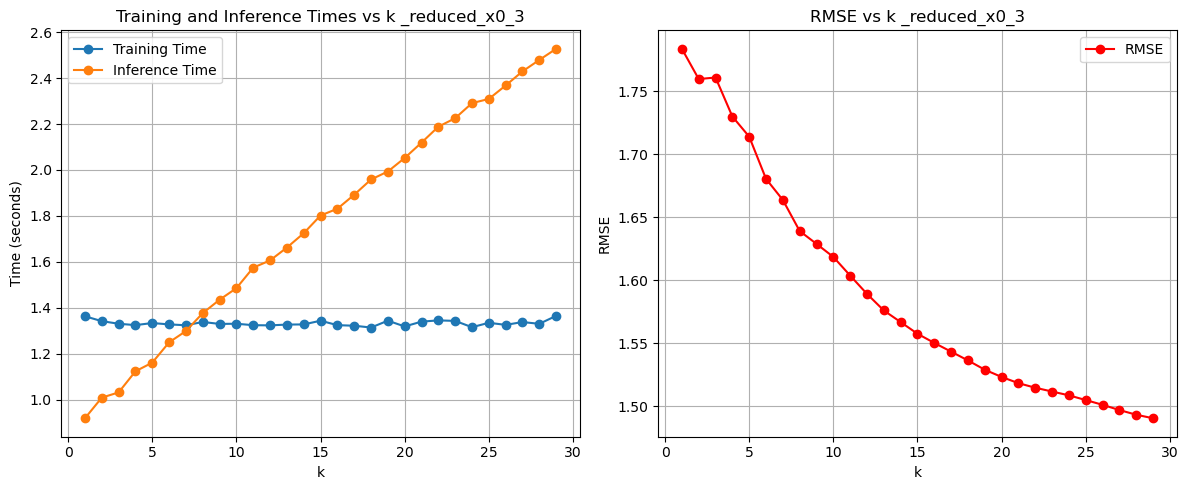

RMSE red x0_3: 1.490609


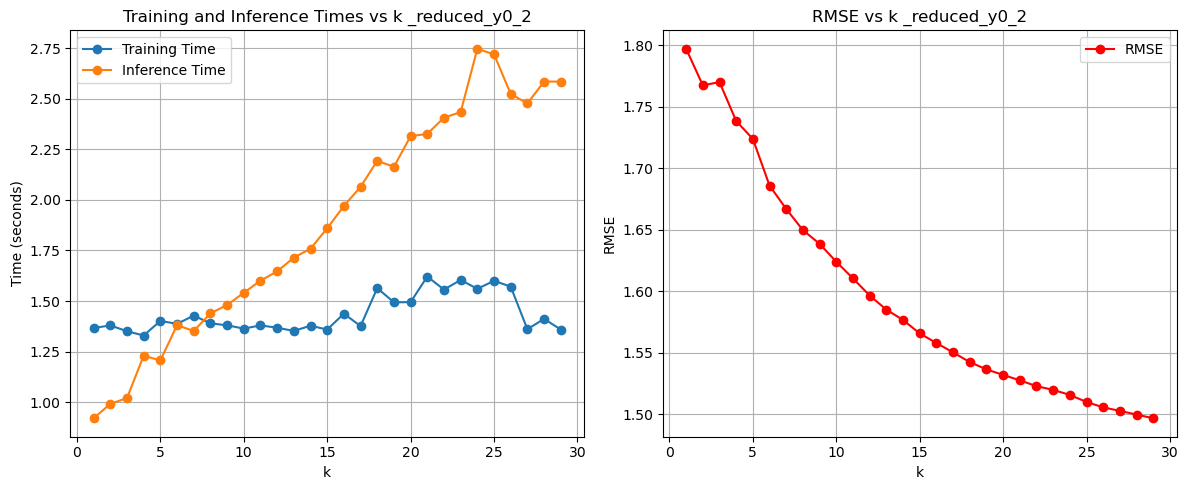

RMSE red y0_2: 1.496682


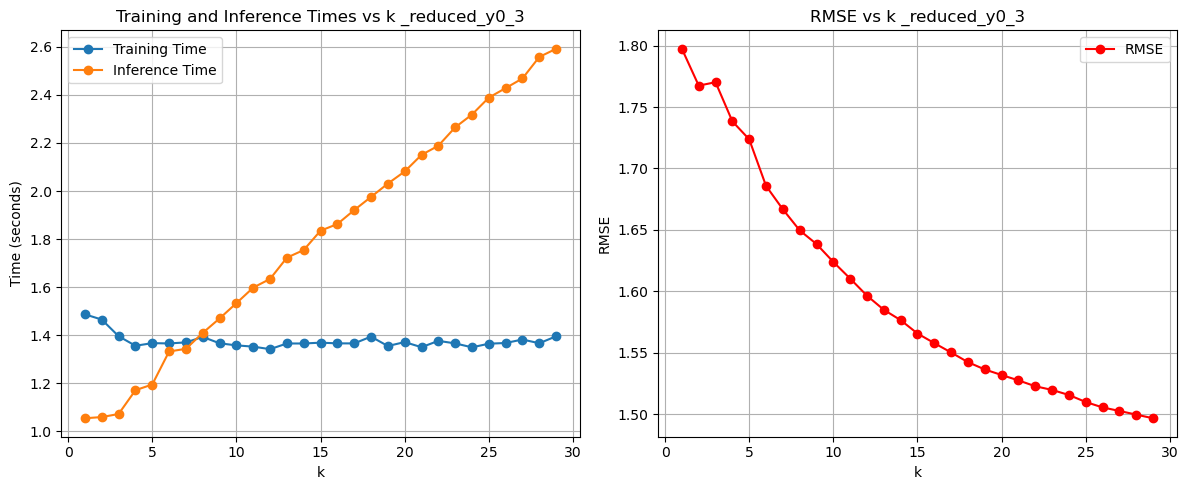

RMSE red y0_3: 1.496701


In [ ]:
remove_features = ['x0_3', 'y0_2', 'y0_3']
rmses_removal = {}
current_cols = feature_cols.copy()

for feat in remove_features:
    reduced_cols = [col for col in current_cols if col != feat]
    X_train_red = X_train_final[reduced_cols]
    X_val_red = X_val_final[reduced_cols]
    
    results_red = validate_knn_regression(X_train_red, y_train_final, X_val_red, y_val_final)
    plot_times_and_rmse(results_red, title_suffix=f"_reduced_{feat}")
    
    min_rmse_red = min(results_red['rmse'])
    rmses_removal[feat] = min_rmse_red
    print(f"RMSE red {feat}: {min_rmse_red:.6f}")

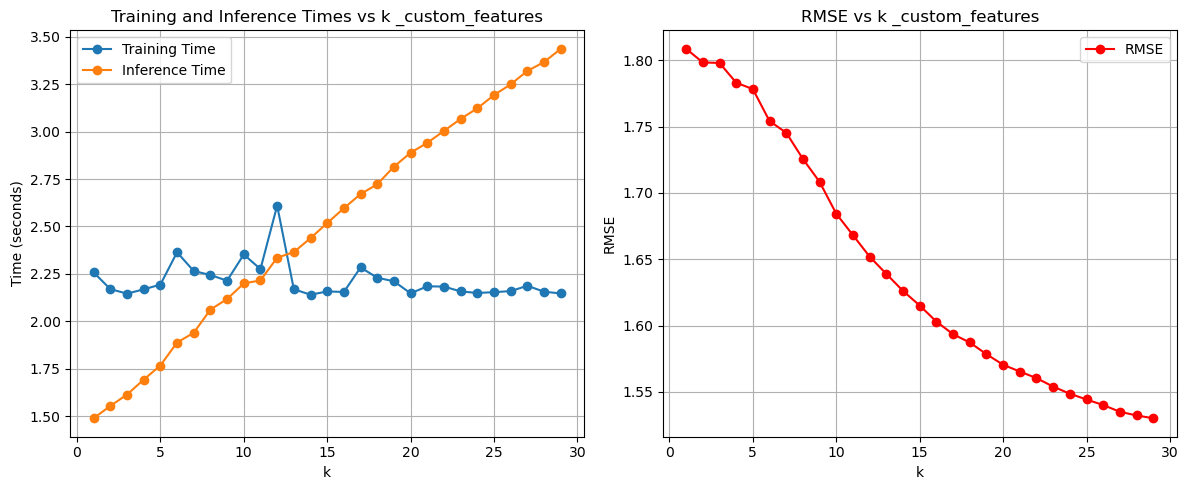

Melhor k custom: 29 com RMSE: 1.530053


In [66]:
X_train_joined_aug = add_custom_features(X_train_joined)
feature_cols_aug =  feature_cols + ['dist_12', 'dist_13', 'dist_23']
X_train_aug = X_train_joined_aug.loc[X_train_split.index, feature_cols_aug]  
X_val_aug = X_train_joined_aug.loc[X_val_split.index, feature_cols_aug]

results_custom = validate_knn_regression(X_train_aug, y_train_final, X_val_aug, y_val_final)
plot_times_and_rmse(results_custom, title_suffix="_custom_features")

best_k_custom = results_custom['k_values'][np.argmin(results_custom['rmse'])]
min_rmse_custom = min(results_custom['rmse'])
print(f"Melhor k custom: {best_k_custom} com RMSE: {min_rmse_custom:.6f}")

In [67]:
# Comparação de RMSEs mínimos 
print("\nComparação de RMSEs:")
print("Base:", min_rmse_base)
print("Remoções:", rmses_removal)
print("Custom:", min_rmse_custom)


Comparação de RMSEs:
Base: 1.5035723662828602
Remoções: {'x0_3': 1.4906093003492216, 'y0_2': 1.496682239445001, 'y0_3': 1.4967009389655948}
Custom: 1.530053439044635


In [70]:
reduced_cols=['t','x0_1','y0_1','x0_2','y0_2','y0_3']
X_train_best = X_train_final[reduced_cols]
X_val_best = X_val_final[reduced_cols]

results_red = validate_knn_regression(X_train_best, y_train_final, X_val_best, y_val_final)
best_k = results_red['k_values'][np.argmin(results_custom['rmse'])]

min_rmse_best = min(results_red['rmse'])

1.4906093003492216


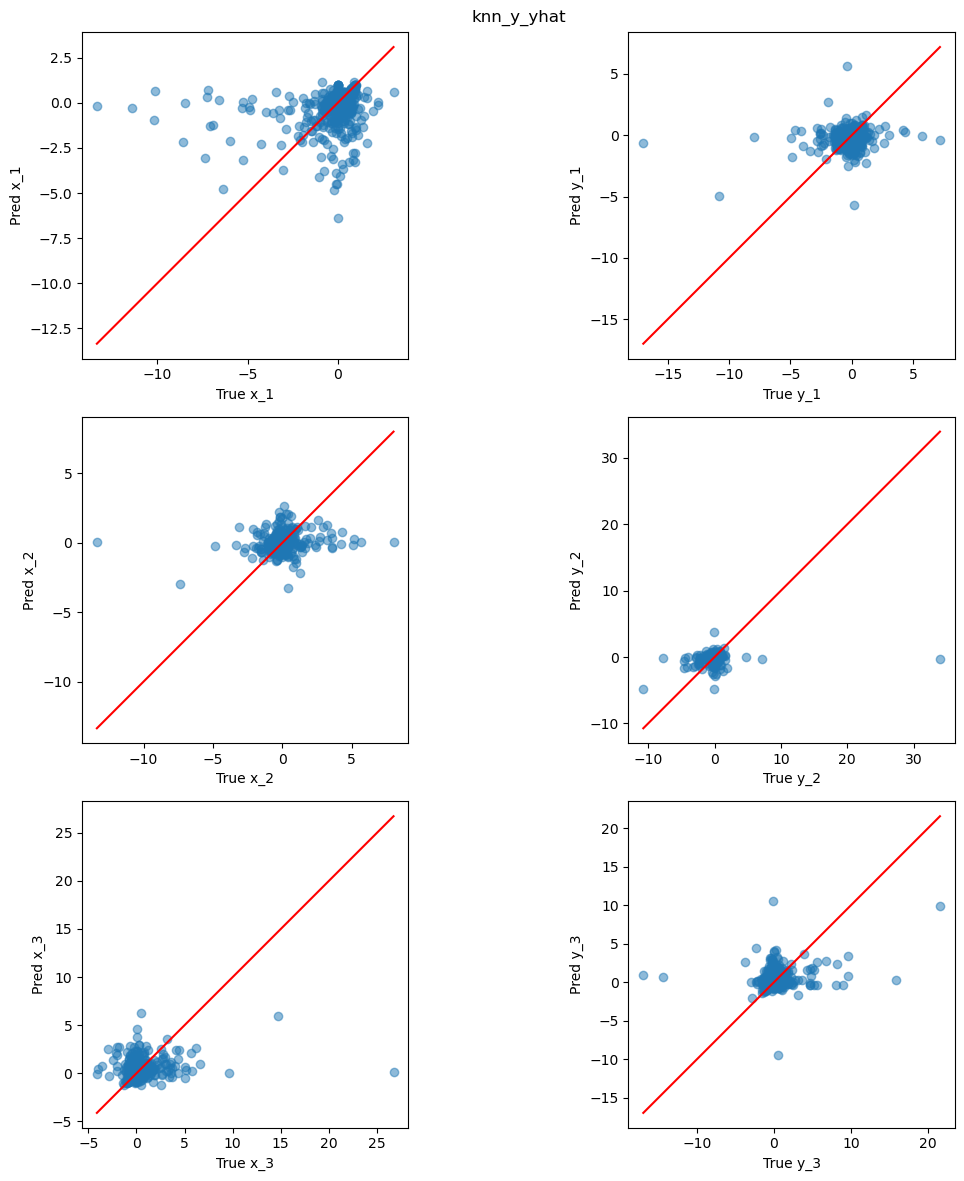

<Figure size 640x480 with 0 Axes>

In [72]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_best)
X_val_scaled = scaler.transform(X_val_best)

knn_best = KNeighborsRegressor(n_neighbors=best_k_custom, metric='euclidean')
knn_best.fit(X_train_scaled, y_train_final)

y_pred_knn = knn_best.predict(X_val_scaled)
rmse_knn = np.sqrt(mean_squared_error(y_val_final, y_pred_knn))
print(rmse_knn)
plot(y_val_final, y_pred_knn, plot_title="knn_y_yhat")

In [81]:
X_test_k = X_test[reduced_cols]
predictions_k = knn_best.predict(X_test_k)
predictions_df_k = pd.DataFrame(predictions_k, columns=target_cols)
predictions_df_k.insert(0, 'id', range(len(predictions_k)))
predictions_df_k.to_csv('knn_submission.csv', index=False)

c:\Users\SofiaG\anaconda3\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but KNeighborsRegressor was fitted without feature names
  warnings.warn(


é comum que o kNN (um modelo não-paramétrico e baseado em instâncias) dê resultados piores em problemas como o Three-Body Problem comparado a modelos paramétricos como Linear Regression (de Task 2/3), especialmente se o dataset for grande ou as relações forem lineares/aproximáveis. O kNN é sensível a ruído, dimensionalidade e escala, e no three-body (um sistema caótico e não-linear), ele pode capturar padrões locais bem, mas sofre com "curse of dimensionality" ou falta de features informativas
